In [42]:
#!pip install git+git://github.com/fchollet/keras.git --upgrade --no-deps

#Import

In [43]:

import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import os
import csv
import pandas as pd
import math

from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from matplotlib import image
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import image

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


import gc
import random
"""
print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""


'\nprint("Tensorflow version %s" %tf.__version__)\n\ndevice_name = tf.test.gpu_device_name()\nif device_name != \'/device:GPU:0\':\n  raise SystemError(\'GPU device not found\')\nprint(\'Found GPU at: {}\'.format(device_name))\n'

#Link the gdrive

In [44]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [45]:
"""!pip install shutil
import shutil

count =0
dest = "/gdrive/My Drive/NN_Dataset/DDSM_Resized"
source = "/gdrive/My Drive/NN_Dataset/DDSM"
folders = ["/BENIGN(PNG)/","/CANCER(PNG)/","/NORMAL(PNG)/"]
for folder in folders:
    if folder=="desktop.ini":
        continue
    path = source+folder
    for part in os.listdir(path):
        print("DOING -- ",folder,part)
        if part=="desktop.ini" or "_10" in part or "_11" in part or "_12" in part or "_01" in part:
            continue
        for case in os.listdir(path+part):
            if case=="desktop.ini":
                continue
            count+=1
            for over in os.listdir(path+part+"/"+case):    
                if over=="desktop.ini":
                   continue
                if ".OVERLAY" in over:
                    #nametow=dest+folder+"/"+part+"/"+case+"/"+image
                    #path_toImg=path+part+"/"+case+"/"+image
                    #image_decoded = tf.image.decode_png(tf.io.read_file(path_toImg), channels=3)

                    #arr_=flipIfNecessary(
                    #    tf.image.resize(
                    #     image_decoded/255, (512,512), method="nearest")
                    #)
                    #im= image_crop(arr_)
                    #tf.keras.preprocessing.image.save_img(nametow,im)
                    shutil.copyfile(path+part+"/"+case+"/"+over,dest+folder+part+"/"+case+"/"+over )
                    
                    
                    
print(count)"""

'!pip install shutil\nimport shutil\n\ncount =0\ndest = "/gdrive/My Drive/NN_Dataset/DDSM_Resized"\nsource = "/gdrive/My Drive/NN_Dataset/DDSM"\nfolders = ["/BENIGN(PNG)/","/CANCER(PNG)/","/NORMAL(PNG)/"]\nfor folder in folders:\n    if folder=="desktop.ini":\n        continue\n    path = source+folder\n    for part in os.listdir(path):\n        print("DOING -- ",folder,part)\n        if part=="desktop.ini" or "_10" in part or "_11" in part or "_12" in part or "_01" in part:\n            continue\n        for case in os.listdir(path+part):\n            if case=="desktop.ini":\n                continue\n            count+=1\n            for over in os.listdir(path+part+"/"+case):    \n                if over=="desktop.ini":\n                   continue\n                if ".OVERLAY" in over:\n                    #nametow=dest+folder+"/"+part+"/"+case+"/"+image\n                    #path_toImg=path+part+"/"+case+"/"+image\n                    #image_decoded = tf.image.decode_png(tf.io.re

#Define global variable

In [46]:
folders=["/BENIGN(PNG)/benign_","/CANCER(PNG)/cancer_"]#,"/NORMAL(PNG)/normal_"]

case=""
left_cc=""
left_mlo=""
right_cc=""
right_mlo=""
lb=0
lm=0
rb=0
rm=0

in_channel=3
img_rows, img_cols=512, 384

AUTOTUNE = tf.data.experimental.AUTOTUNE
numbers= ['02/', '04/', '03/', '05/', '08/', '09/', '01/', '07/', '10/', '06/']
# ['02/', '04/', '06/', '03/', '05/', '10/', '08/', '09/', '01/', '07/']#["01/","02/","03/","04/","05/","06/","07/","08/","09/","10/"]#['03/', '09/', '07/', '08/', '02/', '04/', '06/', '05/',"/01"]#
directory="/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized"
cache="/gdrive/My Drive/Colab_Notebooks/NNPROJECT/cache/"
training="training4"
test="test4"
validation="validation4"

img_size=300
epoch=20
regl2 = 0.0001
lr=0.0001
for_step=15
#random.shuffle(numbers)
print(numbers)

['02/', '04/', '06/', '03/', '05/', '10/', '08/', '09/', '01/', '07/']


In [47]:
mlo_d1_unit=1024
cc_d1_unit=1024

mlo_d2_unit=512
cc_d2_unit=512

d1=64


## Utilities function

In [48]:
def read_spectograms(file_paths, img_rows, img_cols, channels):
  """
  Reads the spectogram files from disk and normalizes the pixel values
    @params:
      file_paths - Array of file paths to read from
      img_rows - The image height.
      img_cols - The image width.
      as_grey - Read the image as Greyscale or RGB.
      channels - Number of channels.
    @returns:
      The created and compiled model (Model)        
  """
  images = []
  
  for file_path in file_paths:
    images.append(imread(file_path))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / 255
  
  # reshape to match Keras expectaions
  #images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images

In [49]:
def binary(x,t=0.5):
  if x>=t :
    return 1
  else:
    return 0

In [50]:
def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights



In [51]:

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return tf.keras.backend.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*tf.keras.backend.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss


In [52]:
def custom_auc(y_true,y_pred):
  roc1=0
  for i in range(0,4):
    m = tf.keras.metrics.AUC(num_thresholds=3)
    m.update_state(y_true[:i], y_pred[:i])
    roc1+=m.result()
  return roc1/4

#Generate the csv for the dataset

##training set

In [53]:

with open(directory+'/training_r.csv', 'w', newline='') as file:

  writer = csv.writer(file)

  for folder in folders:
    for number in numbers[0:7]:#["01/","02/","03/","04/","05/","06/","07/"]:#,

      for i,j,y in os.walk(directory+folder+number,topdown=False):

        if(j):
          for name in j:
            left_cc=""
            left_mlo=""
            right_cc=""
            right_mlo=""
            lb="0"
            rb="0"
            
            lm="0"
            rm="0"
            case=name
            for i2,j2,y2 in os.walk(i+name,topdown=False):
              for name2 in y2:
                if "LEFT_CC.png" in name2:
                  left_cc=i2+"/"+name2
                if "LEFT_MLO.png" in name2:
                  left_mlo=i2+"/"+name2
                if "RIGHT_CC.png" in name2:
                  right_cc= i2+"/"+name2
                if "RIGHT_MLO.png" in name2:
                  right_mlo=i2+"/"+name2

                if "benign" in folder:
                  if name2.endswith(".OVERLAY"):
                    if "LEFT" in name2:
                      lb="1"
                    if "RIGHT" in name2:
                      rb="1"
                if "cancer" in folder:
                  if name2.endswith(".OVERLAY"):
                    if "LEFT" in name2:
                      lm="1"
                    if "RIGHT" in name2:
                      rm="1"
            print([case,left_cc,left_mlo,right_cc,right_mlo,lb,lm,rb,rm])
            writer.writerow([case,left_cc,left_mlo,right_cc,right_mlo,lb,lm,rb,rm])
              


['case1177', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_02/case1177/A_1177_1.LEFT_CC.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_02/case1177/A_1177_1.LEFT_MLO.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_02/case1177/A_1177_1.RIGHT_CC.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_02/case1177/A_1177_1.RIGHT_MLO.png', '0', '0', '1', '0']
['case1266', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_02/case1266/A_1266_1.LEFT_CC.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_02/case1266/A_1266_1.LEFT_MLO.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_02/case1266/A_1266_1.RIGHT_CC.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_02/case1266/A_1266_1.RIGHT_MLO.png', '1', '0', '0', '0']
['case1242', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENI

|Benign 585| cancer 581 | normal 596  |
|----------|------------|-------------|
|right 259 | right  251 | with 4 photos 492| 
|left 287  | left 291   | without 4 photos 104            | 
|both 39   | both 39    |             | 

##validation set

In [54]:
print(numbers[7])
with open(directory+'/validation_r.csv', 'w', newline='') as file:

  writer = csv.writer(file)

  for folder in folders:
    for number in numbers[7:8]:#["01/","02/","03/","04/","05/","06/","07/"]:#,

      for i,j,y in os.walk(directory+folder+number,topdown=False):

        if(j):
          for name in j:
            left_cc=""
            left_mlo=""
            right_cc=""
            right_mlo=""
            lb="0"
            rb="0"
            
            lm="0"
            rm="0"
            case=name
            for i2,j2,y2 in os.walk(i+name,topdown=False):
              for name2 in y2:
                if "LEFT_CC.png" in name2:
                  left_cc=i2+"/"+name2
                if "LEFT_MLO.png" in name2:
                  left_mlo=i2+"/"+name2
                if "RIGHT_CC.png" in name2:
                  right_cc= i2+"/"+name2
                if "RIGHT_MLO.png" in name2:
                  right_mlo=i2+"/"+name2

                if "benign" in folder:
                  if name2.endswith(".OVERLAY"):
                    if "LEFT" in name2:
                      lb="1"
                    if "RIGHT" in name2:
                      rb="1"
                if "cancer" in folder:
                  if name2.endswith(".OVERLAY"):
                    if "LEFT" in name2:
                      lm="1"
                    if "RIGHT" in name2:
                      rm="1"
            print([case,left_cc,left_mlo,right_cc,right_mlo,lb,lm,rb,rm])
            writer.writerow([case,left_cc,left_mlo,right_cc,right_mlo,lb,lm,rb,rm])
              


09/
['case4004', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_09/case4004/D_4004_1.LEFT_CC.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_09/case4004/D_4004_1.LEFT_MLO.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_09/case4004/D_4004_1.RIGHT_CC.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_09/case4004/D_4004_1.RIGHT_MLO.png', '1', '0', '0', '0']
['case4010', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_09/case4010/D_4010_1.LEFT_CC.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_09/case4010/D_4010_1.LEFT_MLO.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_09/case4010/D_4010_1.RIGHT_CC.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_09/case4010/D_4010_1.RIGHT_MLO.png', '1', '0', '0', '0']
['case4011', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/

##Test set

In [55]:
print(numbers[8])
with open(directory+'/test_r.csv', 'w', newline='') as file:

  writer = csv.writer(file)

  for folder in folders:
    for number in [numbers[9]]:#["09/"]: #,"07/","08/","09/"]:
      for i,j,y in os.walk(directory+folder+number,topdown=False):

        if(j):
          for name in j:
            left_cc=""
            left_mlo=""
            right_cc=""
            right_mlo=""
            lb="0"
            rb="0"
            
            lm="0"
            rm="0"
            case=name
            for i2,j2,y2 in os.walk(i+name,topdown=False):
              for name2 in y2:
                if "LEFT_CC.png" in name2:
                  left_cc=i2+"/"+name2
                if "LEFT_MLO.png" in name2:
                  left_mlo=i2+"/"+name2
                if "RIGHT_CC.png" in name2:
                  right_cc= i2+"/"+name2
                if "RIGHT_MLO.png" in name2:
                  right_mlo=i2+"/"+name2

                if "benign" in folder:
                  if name2.endswith(".OVERLAY"):
                    if "LEFT" in name2:
                      lb="1"
                    if "RIGHT" in name2:
                      rb="1"
                if "cancer" in folder:
                  if name2.endswith(".OVERLAY"):
                    if "LEFT" in name2:
                      lm="1"
                    if "RIGHT" in name2:
                      rm="1"
            print([case,left_cc,left_mlo,right_cc,right_mlo,lb,lm,rb,rm])
            writer.writerow([case,left_cc,left_mlo,right_cc,right_mlo,lb,lm,rb,rm])
              


01/
['case1389', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_07/case1389/A_1389_1.LEFT_CC.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_07/case1389/A_1389_1.LEFT_MLO.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_07/case1389/A_1389_1.RIGHT_CC.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_07/case1389/A_1389_1.RIGHT_MLO.png', '1', '0', '0', '0']
['case1418', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_07/case1418/A_1418_1.LEFT_CC.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_07/case1418/A_1418_1.LEFT_MLO.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_07/case1418/A_1418_1.RIGHT_CC.png', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_07/case1418/A_1418_1.RIGHT_MLO.png', '0', '0', '1', '0']
['case1302', '/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/

In [56]:
col=["case","left_cc","left_mlo","right_cc","right_mlo","lb","lm","rb","rm"]
dtypes={"case": "str","left_cc": "str","left_mlo": "str","right_cc": "str","right_mlo": "str","lb": "int","lm": "int","rb": "int","rm": "int"}
df_training=pd.read_csv(directory+'/training_r.csv', sep=',', names=col,dtype=dtypes,  header=None)
df_validation=pd.read_csv(directory+'/validation_r.csv', sep=',', names=col,dtype=dtypes,  header=None)
df_test=pd.read_csv(directory+'/test_r.csv', sep=',', names=col,dtype=dtypes,  header=None)

In [57]:
count=0
rb_c=0
rm_c=0
lm_c=0
lb_c=0
l=0
for index, row in df_training.iterrows():
    """  if row["lm"]==0 and row["rm"]==0 and row["lb"]==0 and row["rb"]==0  :"""
    photo=0
    l+=1
    if(isinstance(row["left_cc"],str)):
      photo+=1
    if(isinstance(row["right_cc"],str)):
      photo+=1
    if(isinstance(row["left_mlo"],str)):
      photo+=1
    if(isinstance(row["right_mlo"],str)):
      photo+=1
    if(photo<4):
      df_training=df_training.drop(index)
      count+=1
    rb_c+=row["rb"]
    rm_c+=row["rm"]
    lm_c+=row["lm"]
    lb_c+=row["lb"]
print(count)

count=0
for index, row in df_validation.iterrows():
    """  if row["lm"]==0 and row["rm"]==0 and row["lb"]==0 and row["rb"]==0  :"""
    photo=0
    l=l+1
    if(isinstance(row["left_cc"],str)):
      photo+=1
    if(isinstance(row["right_cc"],str)):
      photo+=1
    if(isinstance(row["left_mlo"],str)):
      photo+=1
    if(isinstance(row["right_mlo"],str)):
      photo+=1
    if(photo<4):
      df_validation=df_validation.drop(index)
      count+=1
    rb_c+=row["rb"]
    rm_c+=row["rm"]
    lm_c+=row["lm"]
    lb_c+=row["lb"]
print(count)

count=0
for index, row in df_test.iterrows():
    """  if row["lm"]==0 and row["rm"]==0 and row["lb"]==0 and row["rb"]==0  :"""
    photo=0
    l=l+1
    if(isinstance(row["left_cc"],str)):
      photo+=1
    if(isinstance(row["right_cc"],str)):
      photo+=1
    if(isinstance(row["left_mlo"],str)):
      photo+=1
    if(isinstance(row["right_mlo"],str)):
      photo+=1
    if(photo<4):
      df_test=df_test.drop(index)
      count+=1
    rb_c+=row["rb"]
    rm_c+=row["rm"]
    lm_c+=row["lm"]
    lb_c+=row["lb"]
print(count)


print("rb: "+str(rb_c))

print("rm: "+str(rm_c))

print("lb: "+str(lb_c))

print("lm: "+str(lm_c))

print(df_training)
print(df_validation)
print(df_test)


6
1
1
rb: 265
rm: 284
lb: 304
lm: 322
         case                                            left_cc  ... rb rm
0    case1177  /gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Re...  ...  1  0
1    case1266  /gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Re...  ...  0  0
2    case1242  /gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Re...  ...  0  0
3    case1264  /gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Re...  ...  1  0
4    case1170  /gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Re...  ...  1  0
..        ...                                                ...  ... .. ..
869  case1536  /gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Re...  ...  0  0
870  case1557  /gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Re...  ...  0  0
871  case1539  /gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Re...  ...  0  1
872  case1538  /gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Re...  ...  0  0
873  case1535  /gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Re...  ...  0  1

[868 rows x 9 columns]
         case             

#preparing data
##batch size 32 image 
###(estimated time 70s x4 for each batch of image)

senza mutkhitread costa 145 secondi con multithread 50 sec



##Train

###Left

In [ ]:
df_training=df_training.sample(frac=1)
x_train_left_mlo = read_spectograms(df_training.left_mlo.values, img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values, img_rows, img_cols, in_channel)

###Right

In [ ]:
x_train_right_mlo = read_spectograms(df_training.right_mlo.values, img_rows, img_cols, in_channel)
x_train_right_cc= read_spectograms(df_training.right_cc.values, img_rows, img_cols, in_channel)

###labels

In [ ]:

labels = df_training[["lb","lm","rb","rm"]].reset_index(drop=True)
labels=labels.values
w=calculating_class_weights(labels)
l_f=get_weighted_loss(w)
labels

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

###Print examples

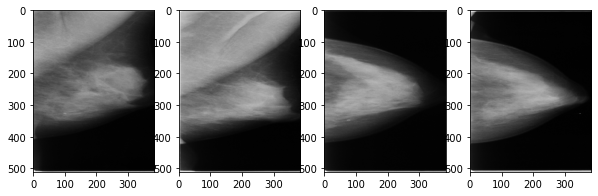

lb, rb, km, rm
[0 0 0 1]
-------


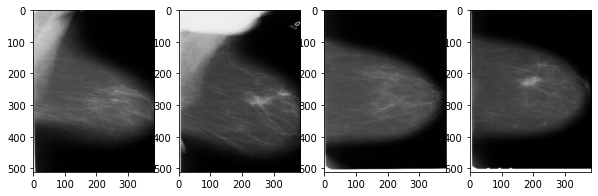

lb, rb, km, rm
[0 0 0 1]
-------


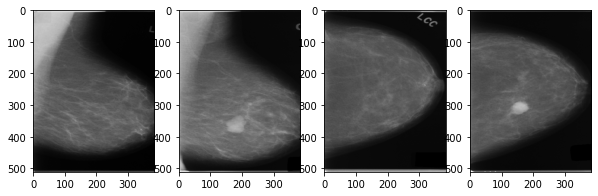

lb, rb, km, rm
[0 0 0 1]
-------


In [ ]:
for j in range(0,3):
  fig=pyplot.figure(figsize=(10, 10))

  fig.add_subplot(1,4, 1)
  pyplot.imshow(x_train_left_mlo[j])


  fig.add_subplot(1,4, 2)
  pyplot.imshow(x_train_right_mlo[j])

  fig.add_subplot(1,4, 3)
  pyplot.imshow(x_train_left_cc[j])

  fig.add_subplot(1,4, 4)
  pyplot.imshow(x_train_right_cc[j])
  
  #fig.set_title(Y["lb"],Y["rb"],Y["lm"],Y["rm"])

  pyplot.show()
  print("lb, rb, km, rm")
  #print(labels.loc[[j]])
  print(labels[j])
  print("-------")
  

##Validation

###Left

In [ ]:
x_validation_left_mlo = read_spectograms(df_validation.left_mlo.values, img_rows, img_cols, in_channel)
x_validation_left_cc= read_spectograms(df_validation.left_cc.values, img_rows, img_cols, in_channel)

###Right

In [ ]:
x_validation_right_mlo = read_spectograms(df_validation.right_mlo.values, img_rows, img_cols, in_channel)
x_validation_right_cc= read_spectograms(df_validation.right_cc.values, img_rows, img_cols, in_channel)

###Labels

In [ ]:


labels_validation = df_validation[["lb","lm","rb","rm"]].reset_index(drop=True)
labels_validation=labels_validation.values
labels_validation

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0,

### Print examples

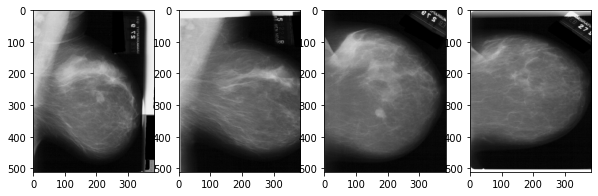

lb, rb, km, rm
[1 0 0 0]
-------


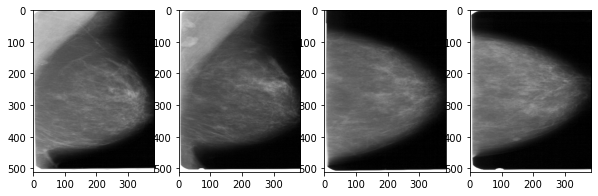

lb, rb, km, rm
[0 0 1 0]
-------


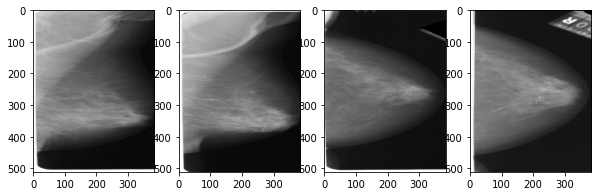

lb, rb, km, rm
[1 0 1 0]
-------


In [ ]:
for j in range(0,3):
  fig=pyplot.figure(figsize=(10, 10))

  fig.add_subplot(1,4, 1)
  pyplot.imshow(x_validation_left_mlo[j])


  fig.add_subplot(1,4, 2)
  pyplot.imshow(x_validation_right_mlo[j])

  fig.add_subplot(1,4, 3)
  pyplot.imshow(x_validation_left_cc[j])

  fig.add_subplot(1,4, 4)
  pyplot.imshow(x_validation_right_cc[j])
  
  #fig.set_title(Y["lb"],Y["rb"],Y["lm"],Y["rm"])

  pyplot.show()
  print("lb, rb, km, rm")
  #print(labels_validation.loc[[j]])
  print(labels_validation[j])
  print("-------")

##Test

In [ ]:
df_test.left_mlo.values[0]

'/gdrive/My Drive/NN_Dataset/RESIZED_V2/DDSM_Resized/BENIGN(PNG)/benign_04/case0254/C_0254_1.LEFT_MLO.png'

In [ ]:
x_test_left_mlo = read_spectograms(df_test.left_mlo.values[0:100], img_rows, img_cols, in_channel)
x_test_left_cc= read_spectograms(df_test.left_cc.values[0:100], img_rows, img_cols, in_channel)

In [ ]:
x_test_right_mlo = read_spectograms(df_test.right_mlo.values[0:100], img_rows, img_cols, in_channel)
x_test_right_cc= read_spectograms(df_test.right_cc.values[0:100], img_rows, img_cols, in_channel)

In [ ]:


labels_test= df_test[["lb","lm","rb","rm"]].reset_index(drop=True)
labels_test=labels_test.values[0:100]
labels_test

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0,

In [ ]:
"""for j in range(0,3):
  fig=pyplot.figure(figsize=(10, 10))

  fig.add_subplot(1,4, 1)
  pyplot.imshow(x_test_left_mlo[j])


  fig.add_subplot(1,4, 2)
  pyplot.imshow(x_test_right_mlo[j])

  fig.add_subplot(1,4, 3)
  pyplot.imshow(x_test_left_cc[j])

  fig.add_subplot(1,4, 4)
  pyplot.imshow(x_test_right_cc[j])
  
  #fig.set_title(Y["lb"],Y["rb"],Y["lm"],Y["rm"])

  pyplot.show()
  print("lb, rb, km, rm")
  #print(labels_validation.loc[[j]])
  print(labels_validation[j])
  print("-------")"""

'for j in range(0,3):\n  fig=pyplot.figure(figsize=(10, 10))\n\n  fig.add_subplot(1,4, 1)\n  pyplot.imshow(x_test_left_mlo[j])\n\n\n  fig.add_subplot(1,4, 2)\n  pyplot.imshow(x_test_right_mlo[j])\n\n  fig.add_subplot(1,4, 3)\n  pyplot.imshow(x_test_left_cc[j])\n\n  fig.add_subplot(1,4, 4)\n  pyplot.imshow(x_test_right_cc[j])\n  \n  #fig.set_title(Y["lb"],Y["rb"],Y["lm"],Y["rm"])\n\n  pyplot.show()\n  print("lb, rb, km, rm")\n  #print(labels_validation.loc[[j]])\n  print(labels_validation[j])\n  print("-------")'

#Model view wise

##resnet block

In [ ]:
#  V 2

def resnetBlock(inputimage,k=2,striede=1, name=""):

  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(inputimage)


  activation=keras.activations.relu(batch_normalize )

  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(3,3),
    name="",
  padding="same"
  )(activation)

  conv1x1_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(1,1),
    name="",
#    activation=keras.activations.relu
  )(activation)


  batch_normalize_2 = keras.layers.BatchNormalization( axis=-1,name="")(conv3x3_1)

  activation2=keras.activations.relu(batch_normalize_2 )
  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    kernel_size=(3,3),
    name="",
    padding="same"
  )(activation2)

  outputs=keras.layers.Add()([conv3x3_1,conv1x1_1])
  return outputs

##resnet layer

In [ ]:
def resNetLayers(inputimage,name=""):
  block1=resnetBlock(inputimage,k=16,name="block1")
  #block2=resnetBlock(block1,k=16,name="block2")
  block3=resnetBlock(block1,k=16,striede=2,name="block3")
  #block4=resnetBlock(block3,k=32,name="block4")
  block5=resnetBlock(block3,k=32,striede=2,name="block5")
  pool=keras.layers.AveragePooling2D(
      pool_size=(3,3), strides=2, padding='same', name='' #(3,3)
  )(block5)
  #block6=resnetBlock(block5,k=32,striede=2,name="block6")
  block7=resnetBlock(pool,k=32,striede=2,name="block7")
  #block8=resnetBlock(inputfilter=128,k=128,name="block8")(block7)
  
  #block10=resnetBlock(inputfilter=256,k=256,name="block10")(block9)
  return block7


##single view resnet

In [ ]:
def singleViewResnet(inputimage, name=""):

  conv7x7=tf.keras.layers.Conv2D(
    filters=16,
    strides=2,
    kernel_size=(5,5),
    name="",
    activation=keras.activations.relu
  )(inputimage)

  pool3x3=keras.layers.AveragePooling2D(
      pool_size=(2,2), strides=2, padding='same', name='' #(3,3)
  )(conv7x7)

  resNetL=resNetLayers(pool3x3,name="")
  print(resNetL.shape)
  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(resNetL)

  relu=keras.activations.relu(batch_normalize)
  
  return relu



##view wise

In [ ]:
def view_wise(img_rows=300, img_cols=300):
  left_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_cc")
  right_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_cc"
  )  

  left_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_mlo"
  )  
  right_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_mlo"
  )


  cc_resnet_left=singleViewResnet(left_cc_input)
  cc_resnet_right=singleViewResnet(right_cc_input)

  mlo_resnet_left=singleViewResnet(left_mlo_input)
  mlo_resent_right=singleViewResnet(right_mlo_input)

  avg_pool_cc_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_left)
  avg_pool_cc_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_right)

  avg_pool_mlo_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resnet_left)
  avg_pool_mlo_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resent_right)

  mlo=keras.layers.Concatenate(axis=-1)([avg_pool_mlo_left, avg_pool_mlo_right])
  cc=keras.layers.Concatenate(axis=-1)([avg_pool_cc_left, avg_pool_cc_right])

  mlo_flatten=tf.keras.layers.Flatten()(mlo)
  cc_flatten=tf.keras.layers.Flatten()(cc)


  mlo_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_flatten)
        )
      )
  mlo_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_dense1)
        )
      ) 
  
  mlo_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(mlo_dense3)
    )


  cc_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_flatten)
        )
      )
  cc_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_dense1)
        )
      ) 
 
  cc_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(cc_dense3)
    )
  


  output=keras.layers.Average(name="outpu")([cc_dense2,mlo_dense2])

  output=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(output)
    )
  
 
  output=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(output)
    )

  return keras.Model(
      inputs=[left_cc_input, right_cc_input, left_mlo_input, right_mlo_input],
      outputs=output,name="view-wise"
  )





## build the model

(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Model: "view-wise"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_cc (InputLayer)            [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_cc (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
left_mlo (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_mlo (InputLayer)          [(None, 512, 384, 3) 0                                            
______________________

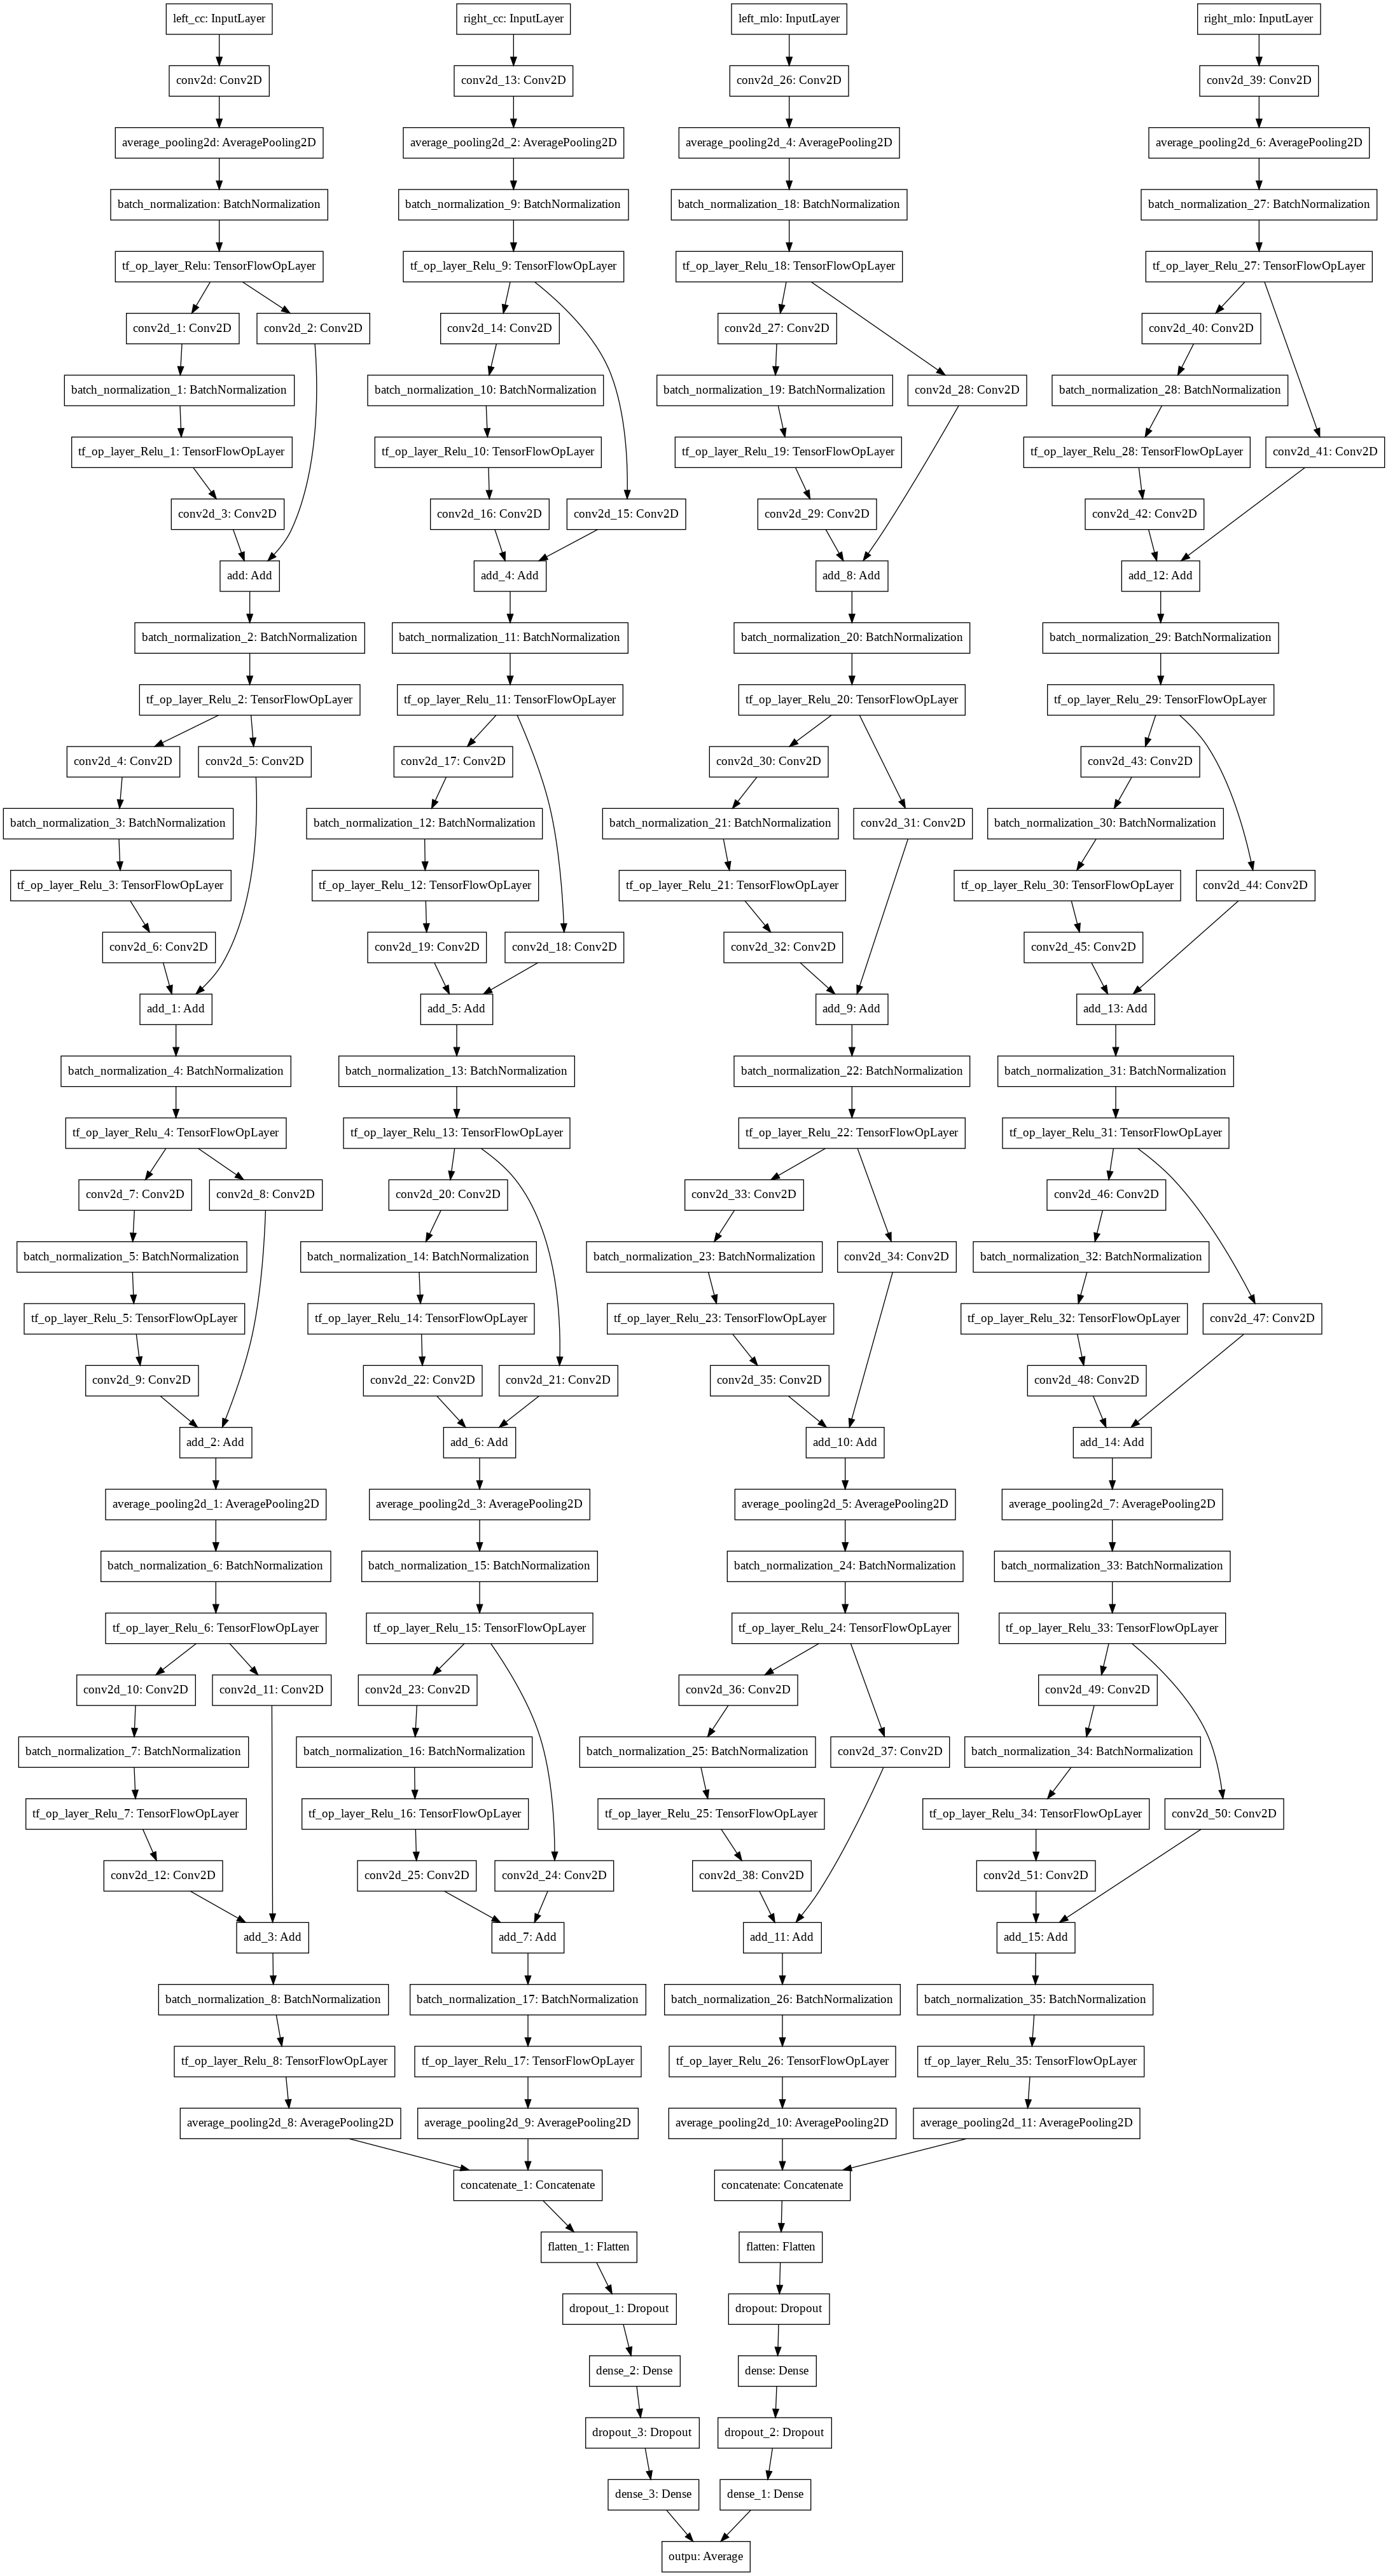

In [ ]:


gc.collect()
model=view_wise(img_rows, img_cols)
model.summary()
keras.utils.plot_model(model, "/view-wise.png", show_shapes=False, expand_nested=False)

### Train the model

In [ ]:
batch_size=32
step_per_epoch=len(x_train_left_mlo)/batch_size

model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss=l_f,
              metrics=[tf.keras.metrics.AUC(name="auc",multi_label=False,num_thresholds=100),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history=model.fit(x={"left_mlo": x_train_left_mlo,
                         "left_cc": x_train_left_cc,
                         "right_mlo":x_train_right_mlo,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=epoch+80,verbose=1,
                  batch_size=32,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "left_cc": x_validation_left_cc,
                         "right_mlo":x_validation_right_mlo,
                         "right_cc":x_validation_right_cc},
                         labels_validation
                  )
                  )

Epoch 1/100
24/24 [==============================] - 13s 535ms/step - loss: 0.8651 - auc: 0.5983 - binary_accuracy: 0.5691 - val_loss: 0.8785 - val_auc: 0.5034 - val_binary_accuracy: 0.5000
Epoch 2/100
24/24 [==============================] - 11s 440ms/step - loss: 0.8192 - auc: 0.6611 - binary_accuracy: 0.6222 - val_loss: 0.8718 - val_auc: 0.5066 - val_binary_accuracy: 0.5547
Epoch 3/100
24/24 [==============================] - 10s 435ms/step - loss: 0.7866 - auc: 0.6998 - binary_accuracy: 0.6429 - val_loss: 0.8951 - val_auc: 0.5004 - val_binary_accuracy: 0.5584
Epoch 4/100
24/24 [==============================] - 10s 429ms/step - loss: 0.7609 - auc: 0.7307 - binary_accuracy: 0.6776 - val_loss: 0.9051 - val_auc: 0.5276 - val_binary_accuracy: 0.5821
Epoch 5/100
24/24 [==============================] - 10s 427ms/step - loss: 0.7442 - auc: 0.7456 - binary_accuracy: 0.6893 - val_loss: 0.9608 - val_auc: 0.5289 - val_binary_accuracy: 0.5018
Epoch 6/100
24/24 [==============================]

#### Result

In [ ]:
for i in history.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history.history[i], label='train')
  pyplot.plot(history.history['val_'+i], label='val')
  plt.legend(loc="upper left")
  pyplot.show()


#Model view wise trained per part

In [ ]:
model=[]
gc.collect()

8738

##Part mlo

In [ ]:
def view_wise_mlo(img_rows=300, img_cols=300):

  left_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_mlo"
  )  
  right_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_mlo"
  )

  #cc_resnet=singleViewResnet(name="cc_resnet")
  #mlo_resnet=singleViewResnet(name="mlo_resnet")


  mlo_resnet_left=singleViewResnet(left_mlo_input)
  mlo_resent_right=singleViewResnet(right_mlo_input)


  avg_pool_mlo_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resnet_left)
  avg_pool_mlo_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resent_right)

  mlo=keras.layers.Concatenate(axis=-1)([avg_pool_mlo_left, avg_pool_mlo_right])
  mlo_flatten=tf.keras.layers.Flatten()(mlo)

  
  mlo_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_flatten)
        )
      )
  mlo_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_dense1)
        )
      ) 
  
  mlo_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(mlo_dense3)
    )
  

  output=mlo_dense2
  return keras.Model(
      inputs=[left_mlo_input, right_mlo_input],
      outputs=output,name="view-wise"
  )

##Part cc

In [ ]:
def view_wise_cc(img_rows=300, img_cols=300):
  left_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_cc")
  right_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_cc"
  )  

  #cc_resnet=singleViewResnet(name="cc_resnet")
  #mlo_resnet=singleViewResnet(name="mlo_resnet")

  cc_resnet_left=singleViewResnet(left_cc_input)
  cc_resnet_right=singleViewResnet(right_cc_input)


  avg_pool_cc_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_left)
  avg_pool_cc_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_right)


  cc=keras.layers.Concatenate(axis=-1)([avg_pool_cc_left, avg_pool_cc_right])

  cc_flatten=tf.keras.layers.Flatten()(cc)

  

  cc_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_flatten)
        )
      )
  cc_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_dense1)
        )
      ) 
 
  cc_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(cc_dense3)
    )
  

  output=cc_dense2
  return keras.Model(
      inputs=[left_cc_input, right_cc_input],
      outputs=output,name="view-wise"
  )

## Build mlo

(None, 8, 6, 32)
(None, 8, 6, 32)
Model: "view-wise"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_mlo (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_mlo (InputLayer)          [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 254, 190, 16) 1216        left_mlo[0][0]                   
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 254, 190, 16) 1216        right_mlo[0][0]                  
________________________________________________________

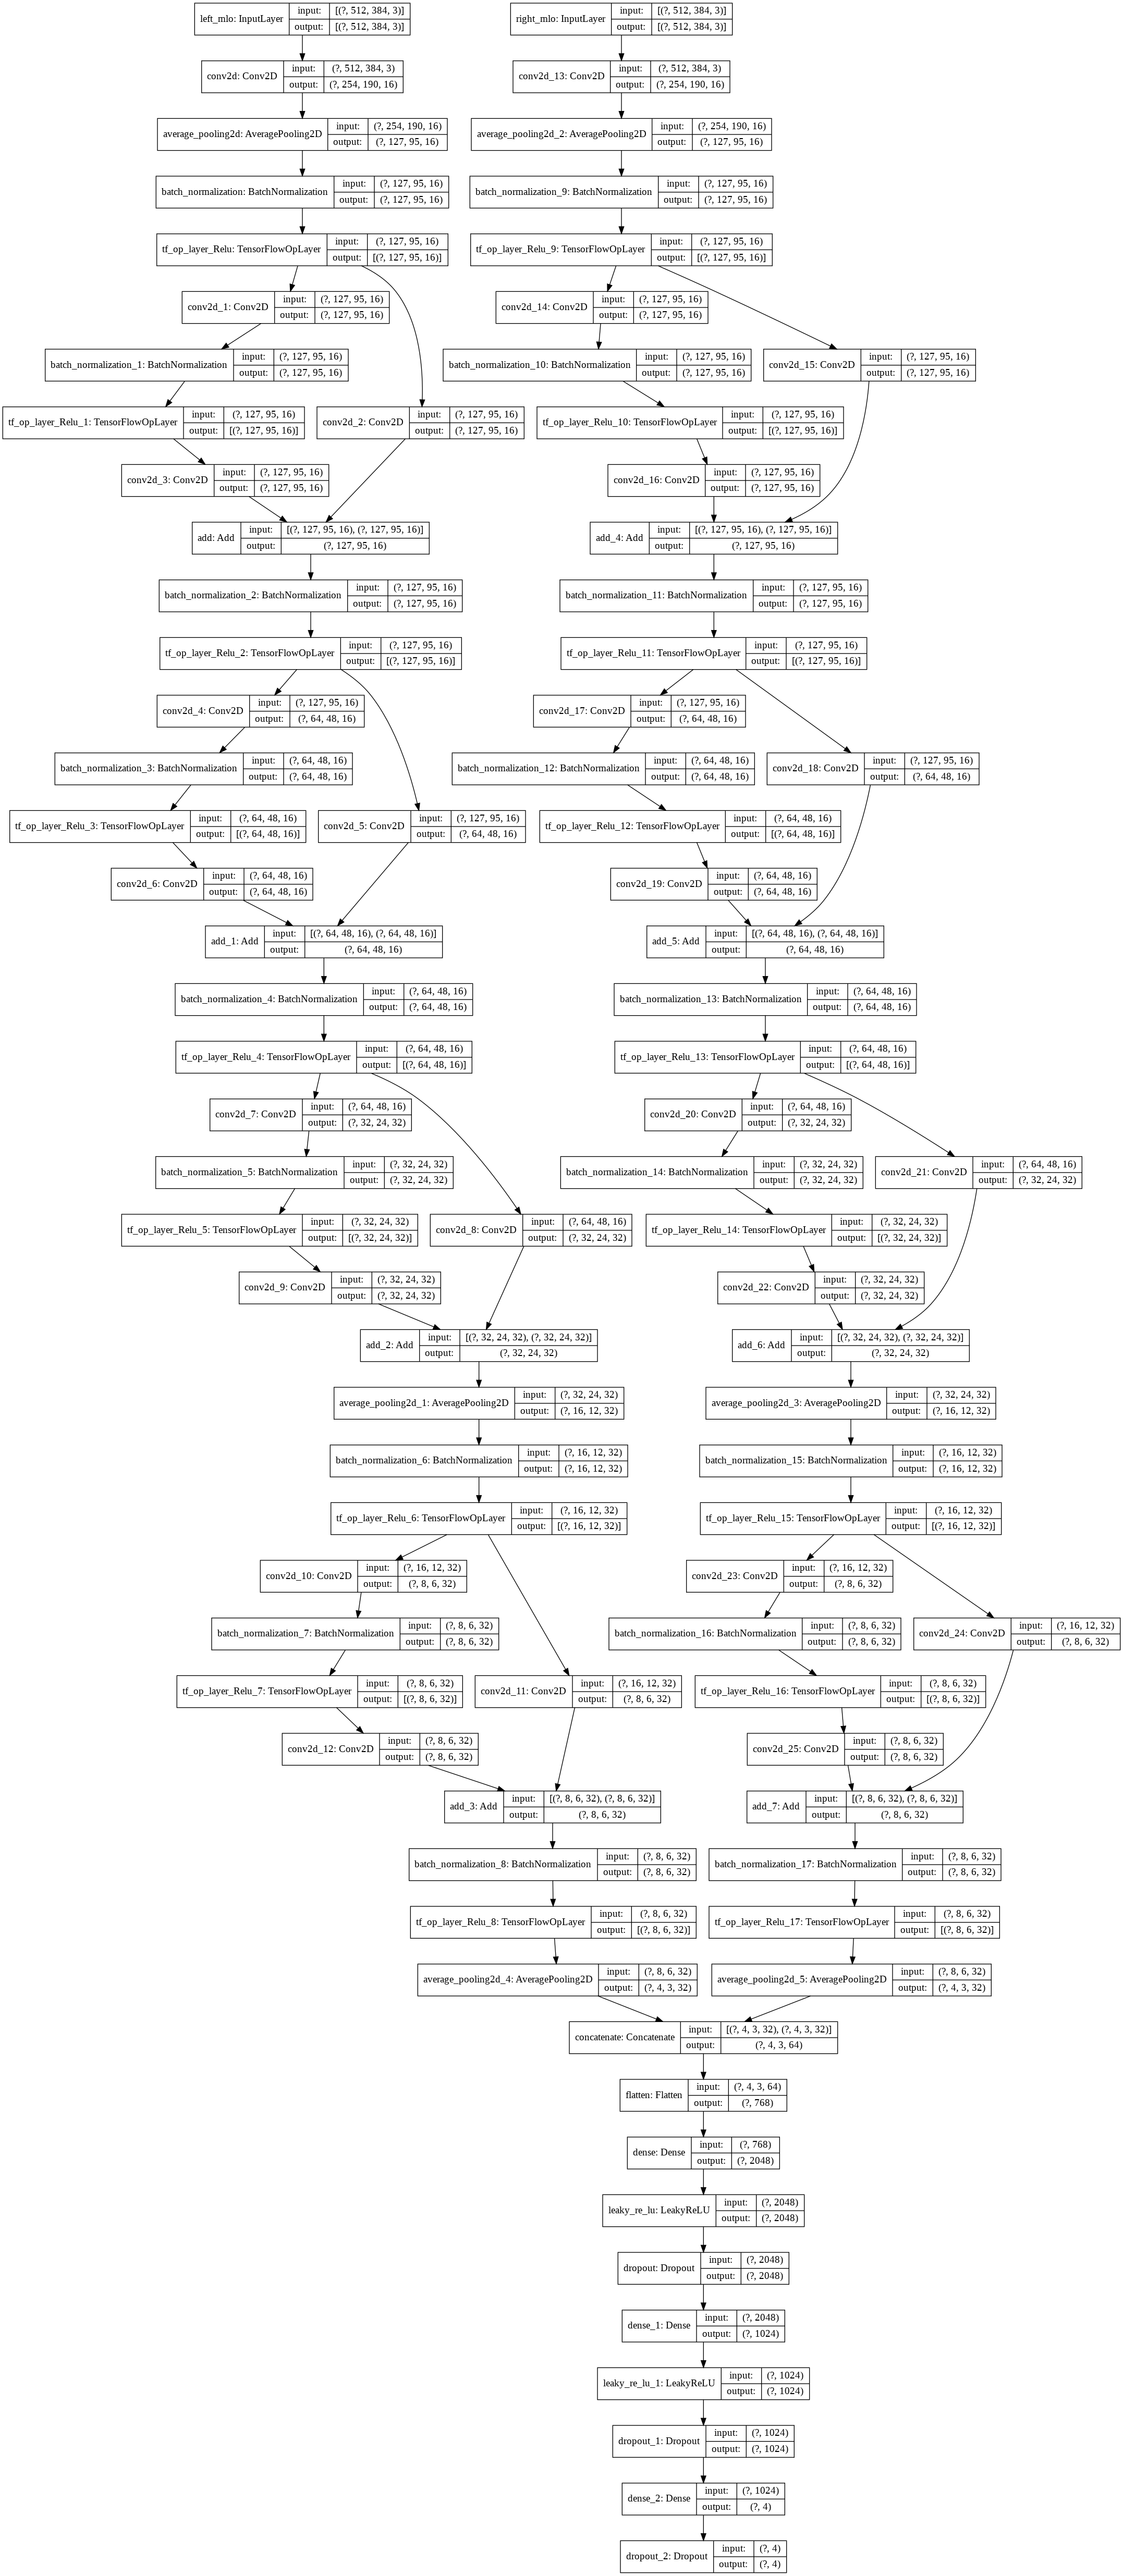

In [ ]:
model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.summary()
keras.utils.plot_model(model_mlo, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise_mlo.png", show_shapes=True, expand_nested=False)

##Build cc

(None, 8, 6, 32)
(None, 8, 6, 32)
Model: "view-wise"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_cc (InputLayer)            [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_cc (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 254, 190, 16) 1216        left_cc[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 254, 190, 16) 1216        right_cc[0][0]                   
________________________________________________________

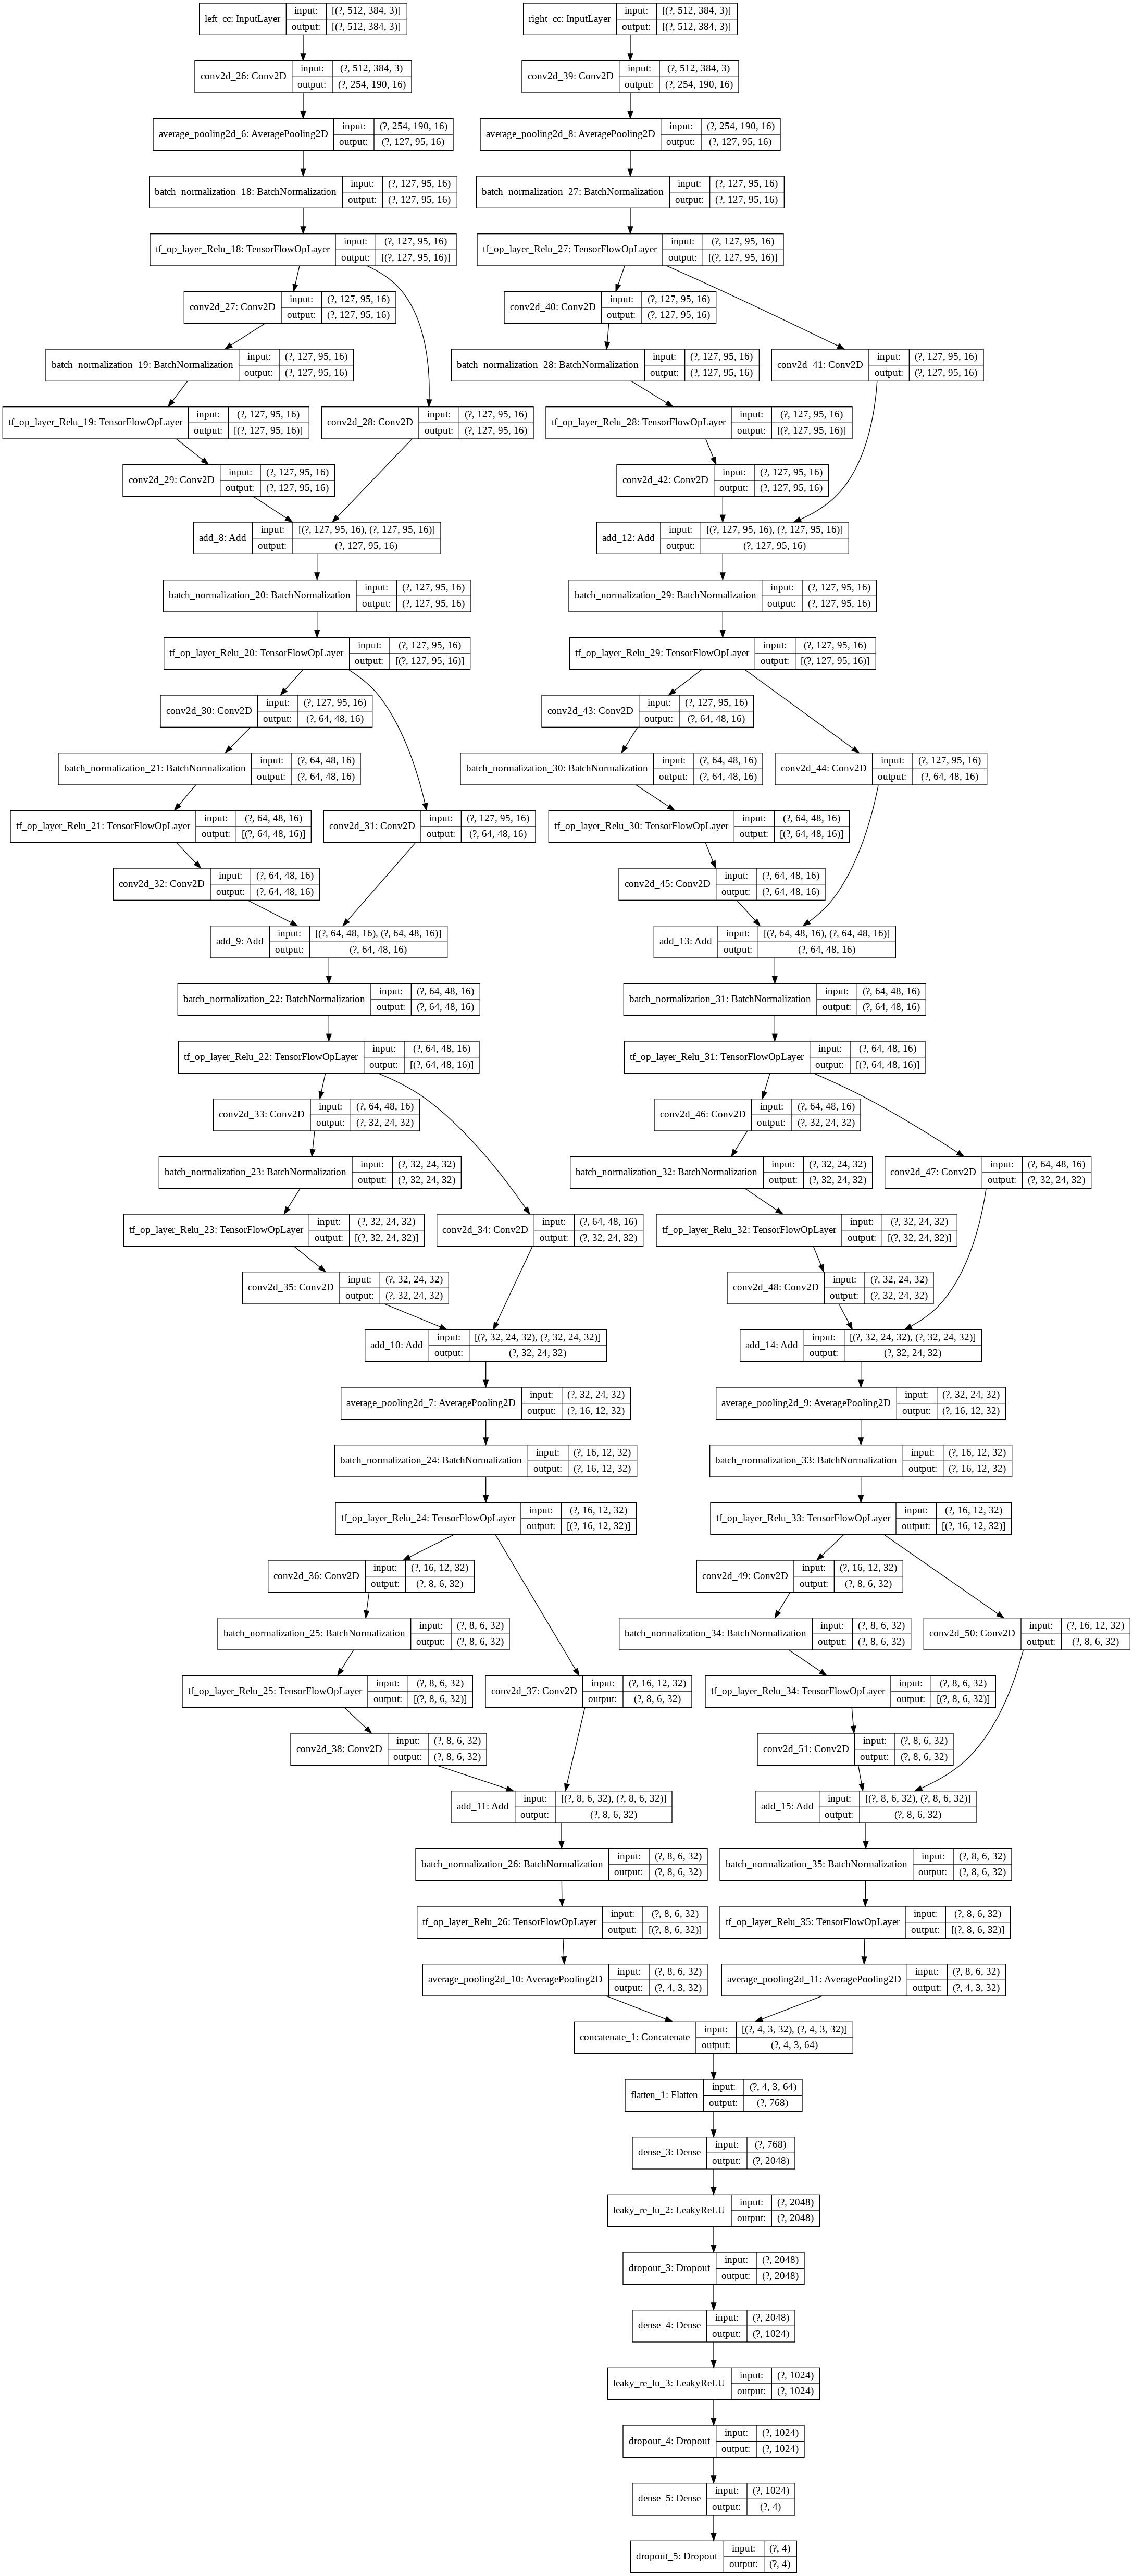

In [ ]:
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.summary()
keras.utils.plot_model(model_cc, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise_cc.png", show_shapes=True, expand_nested=False)

###training different part

In [ ]:
batch_size=32
step_per_epoch=len(x_train_left_mlo)/batch_size

model_cc.compile(optimizer=keras.optimizers.SGD(lr=0.001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_cc=model_cc.fit(x={
                         "left_cc": x_train_left_cc,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=50,verbose=1,

                  validation_data=(
                      {
                         "left_cc": x_validation_left_cc,

                         "right_cc":x_validation_right_cc},
                         labels_validation
                  ))

Epoch 1/50
25/25 [==============================] - 5s 191ms/step - loss: 0.8871 - auc: 0.5215 - binary_accuracy: 0.6610 - val_loss: 0.9234 - val_auc: 0.6412 - val_binary_accuracy: 0.7437
Epoch 2/50
25/25 [==============================] - 3s 131ms/step - loss: 0.8675 - auc: 0.5299 - binary_accuracy: 0.7014 - val_loss: 0.9037 - val_auc: 0.6537 - val_binary_accuracy: 0.7437
Epoch 3/50
25/25 [==============================] - 3s 128ms/step - loss: 0.8518 - auc: 0.5482 - binary_accuracy: 0.7146 - val_loss: 0.8861 - val_auc: 0.6429 - val_binary_accuracy: 0.7437
Epoch 4/50
25/25 [==============================] - 3s 133ms/step - loss: 0.8355 - auc: 0.5820 - binary_accuracy: 0.7306 - val_loss: 0.8712 - val_auc: 0.6416 - val_binary_accuracy: 0.7437
Epoch 5/50
25/25 [==============================] - 3s 128ms/step - loss: 0.8374 - auc: 0.5642 - binary_accuracy: 0.7271 - val_loss: 0.8589 - val_auc: 0.6440 - val_binary_accuracy: 0.7437
Epoch 6/50
25/25 [==============================] - 3s 131ms

#### Result cc

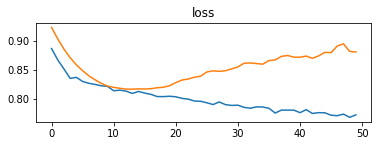

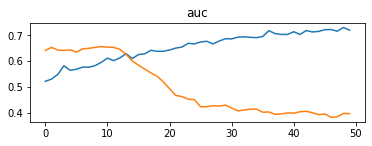

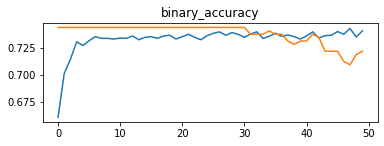

In [ ]:
for i in history_cc.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_cc.history[i], label='train')
  pyplot.plot(history_cc.history['val_'+i], label='test')
  pyplot.show()

In [ ]:
batch_size=32
step_per_epoch=len(x_train_left_mlo)/batch_size

model_mlo.compile(optimizer=keras.optimizers.SGD(lr=0.001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_mlo=model_mlo.fit(x={"left_mlo": x_train_left_mlo,
                         "right_mlo":x_train_right_mlo,},
                  y=labels,
                  epochs=50,verbose=1,

                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "right_mlo":x_validation_right_mlo,
                       },
                         labels_validation
                  ))

Epoch 1/50
25/25 [==============================] - 4s 161ms/step - loss: 0.9560 - auc: 0.4769 - binary_accuracy: 0.5379 - val_loss: 0.9381 - val_auc: 0.3963 - val_binary_accuracy: 0.5375
Epoch 2/50
25/25 [==============================] - 3s 137ms/step - loss: 0.9066 - auc: 0.4858 - binary_accuracy: 0.6272 - val_loss: 0.9297 - val_auc: 0.4116 - val_binary_accuracy: 0.7406
Epoch 3/50
25/25 [==============================] - 4s 140ms/step - loss: 0.8808 - auc: 0.5108 - binary_accuracy: 0.6826 - val_loss: 0.9192 - val_auc: 0.4882 - val_binary_accuracy: 0.7437
Epoch 4/50
25/25 [==============================] - 4s 141ms/step - loss: 0.8648 - auc: 0.5174 - binary_accuracy: 0.7140 - val_loss: 0.9092 - val_auc: 0.4971 - val_binary_accuracy: 0.7437
Epoch 5/50
25/25 [==============================] - 4s 141ms/step - loss: 0.8548 - auc: 0.5166 - binary_accuracy: 0.7218 - val_loss: 0.8997 - val_auc: 0.4665 - val_binary_accuracy: 0.7437
Epoch 6/50
25/25 [==============================] - 3s 138ms

#### Result mlo

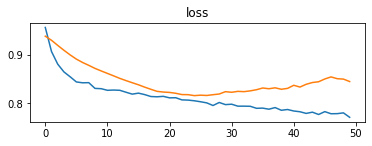

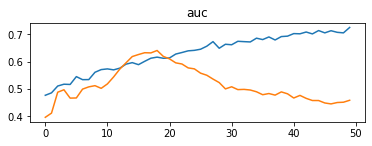

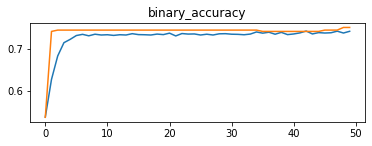

In [ ]:
for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_mlo.history[i], label='train')
  pyplot.plot(history_mlo.history['val_'+i], label='test')
  pyplot.show()


##Cobine Part


In [ ]:
def model_view_wise_combined(img_rows=300, img_cols=300):
  left_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_cc")
  right_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_cc"
  )  

  left_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_mlo"
  )  
  right_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_mlo"
  )

  cc=model_cc.layers
  mlo=model_mlo.layers
  for i in cc:
    i.trainable=True
  for i in mlo:
    i.trainable=True
  for i in cc[0:-1]:
    i.trainable=False
  for i in mlo[0:-1]:
    i.trainable=False
  cc = [layer.output for layer in cc]
  mlo = [layer.output for layer in mlo]

  cc_m=keras.Model(inputs=model_cc.inputs, outputs=cc[-1])
  mlo_m=keras.Model(inputs=model_mlo.inputs, outputs=mlo[-1])

  output1=cc_m({"left_cc": left_cc_input,
                         "right_cc":right_cc_input,})
  
  output2=mlo_m({"left_mlo": left_mlo_input,
                         "right_mlo":right_mlo_input,})

  output=keras.layers.Average(name="outpu")([output1,output2])

  model_composed=keras.Model(
      inputs=[left_cc_input, right_cc_input, left_mlo_input, right_mlo_input],
      outputs=output,name="view-wise"
  )
  return model_composed

In [ ]:
model_composed=model_view_wise_combined(img_rows, img_cols)
model_composed.summary()
keras.utils.plot_model(model_composed, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise_composed.png", show_shapes=True, expand_nested=False)

### Training the combined

In [ ]:
batch_size=32
step_per_epoch=len(x_train_left_mlo)/batch_size

model_composed.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss=l_f,#l_fkeras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_compose=model_composed.fit(x={"left_mlo": x_train_left_mlo,
                         "left_cc": x_train_left_cc,
                         "right_mlo":x_train_right_mlo,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=epoch+80,verbose=1,

                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "left_cc": x_validation_left_cc,
                         "right_mlo":x_validation_right_mlo,
                         "right_cc":x_validation_right_cc},
                         labels_validation
                  ))


#### result combined

In [ ]:
for i in history_compose.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_compose.history[i], label='train')
  pyplot.plot(history_compose.history['val_'+i], label='test')
  pyplot.show()


NameError: ignored

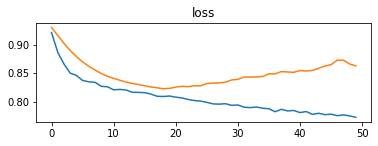

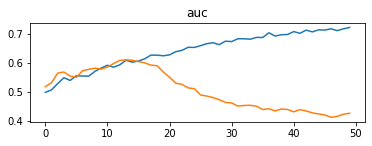

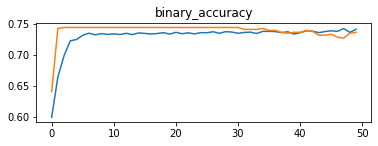

In [ ]:
for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history[i], history_cc.history[i])] , label='train')
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history['val_'+i], history_cc.history['val_'+i])] , label='test')
  pyplot.show()

#Best Model with cross validation

In [ ]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

In [ ]:
labels

In [ ]:
"""x_train_left_mlo = pd.concat(x_train_left_mlo)
x_train_right_mlo = pd.concat(x_train_right_mlo)

x_train_left_cc = pd.concat(x_train_left_cc)
x_train_right_cc = pd.concat(x_train_right_cc)

labels = labels"""

##subdivide the dataset


In [ ]:
subsets=[]
index=range(0,1000)
n=int(len(df_training.values)/7)
l=(1000)
"""for i in range(0, 1000, n):
        subsets.append(index[i:i+n])"""
n

In [ ]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]
gc.collect()

labels_c = df_training[["lb","lm","rb","rm"]].reset_index(drop=True)
labels_c=labels_c.values
w=calculating_class_weights(labels_c)
l_f=get_weighted_loss(w)
labels_c

##Model

In [ ]:
#  V 2

def resnetBlock(inputimage,k=2,striede=1, name=""):

  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(inputimage)


  activation=keras.activations.relu(batch_normalize )

  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(3,3),
    name="",
  padding="same"
  )(activation)

  conv1x1_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(1,1),
    name="",
#    activation=keras.activations.relu
  )(activation)


  batch_normalize_2 = keras.layers.BatchNormalization( axis=-1,name="")(conv3x3_1)

  activation2=keras.activations.relu(batch_normalize_2 )
  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    kernel_size=(3,3),
    name="",
    padding="same"
  )(activation2)

  outputs=keras.layers.Add()([conv3x3_1,conv1x1_1])
  return outputs




In [ ]:
def resNetLayers(inputimage,name=""):
  block1=resnetBlock(inputimage,k=16,name="block1")
  #block2=resnetBlock(block1,k=16,name="block2")
  block3=resnetBlock(block1,k=16,striede=2,name="block3")
  #block4=resnetBlock(block3,k=32,name="block4")
  block5=resnetBlock(block3,k=32,striede=2,name="block5")
  pool=keras.layers.AveragePooling2D(
      pool_size=(3,3), strides=2, padding='same', name='' #(3,3)
  )(block5)
  #block6=resnetBlock(block5,k=32,striede=2,name="block6")
  block7=resnetBlock(pool,k=32,striede=2,name="block7")
  #block8=resnetBlock(inputfilter=128,k=128,name="block8")(block7)
  
  #block10=resnetBlock(inputfilter=256,k=256,name="block10")(block9)
  return block7

def singleViewResnet(inputimage, name=""):

  conv7x7=tf.keras.layers.Conv2D(
    filters=16,
    strides=2,
    kernel_size=(5,5),
    name="",
    activation=keras.activations.relu
  )(inputimage)

  pool3x3=keras.layers.AveragePooling2D(
      pool_size=(2,2), strides=2, padding='same', name='' #(3,3)
  )(conv7x7)

  resNetL=resNetLayers(pool3x3,name="")
  print(resNetL.shape)
  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(resNetL)

  relu=keras.activations.relu(batch_normalize)
  
  return relu




In [ ]:
def view_wise(img_rows=300, img_cols=300):
  left_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_cc")
  right_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_cc"
  )  

  left_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_mlo"
  )  
  right_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_mlo"
  )


  cc_resnet_left=singleViewResnet(left_cc_input)
  cc_resnet_right=singleViewResnet(right_cc_input)

  mlo_resnet_left=singleViewResnet(left_mlo_input)
  mlo_resent_right=singleViewResnet(right_mlo_input)

  avg_pool_cc_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_left)
  avg_pool_cc_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_right)

  avg_pool_mlo_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resnet_left)
  avg_pool_mlo_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resent_right)

  mlo=keras.layers.Concatenate(axis=-1)([avg_pool_mlo_left, avg_pool_mlo_right])
  cc=keras.layers.Concatenate(axis=-1)([avg_pool_cc_left, avg_pool_cc_right])

  mlo_flatten=tf.keras.layers.Flatten()(mlo)
  cc_flatten=tf.keras.layers.Flatten()(cc)


  mlo_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_flatten)
        )
      )
  mlo_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_dense1)
        )
      ) 
  
  mlo_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(mlo_dense3)
    )


  cc_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_flatten)
        )
      )
  cc_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_dense1)
        )
      ) 
 
  cc_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(cc_dense3)
    )
  


  output=keras.layers.Average(name="outpu")([cc_dense2,mlo_dense2])

  output=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(output)
    )
  
 
  output=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(output)
    )

  return keras.Model(
      inputs=[left_cc_input, right_cc_input, left_mlo_input, right_mlo_input],
      outputs=output,name="view-wise"
  )
model=view_wise(img_rows, img_cols)
model.summary()
#keras.utils.plot_model(model, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise.png", show_shapes=True, expand_nested=False)




##utilities

In [ ]:
batch_size=32
step_per_epoch=len(x_train_left_mlo)/batch_size

cbks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
        tf.keras.callbacks.ModelCheckpoint(
                    "/checkpoint_auc1",
                    monitor="val_auc",
                    mode='max',
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
                    
        ),
       tf.keras.callbacks.ModelCheckpoint(
                    "/checkpoint_loss1",
                    monitor="val_loss",
                    
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
       )]


optimizer=keras.optimizers.Adam(lr=0.001)
#optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
#optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07)


## Cross Validation 1/5

In [ ]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

gc.collect()

In [ ]:


###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[n:-1], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[n:-1], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[n:-1], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[n:-1], img_rows, img_cols, in_channel)

###labels
labels = labels_c[n:-1]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[0:n], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[0:n], img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[0:n], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[0:n], img_rows, img_cols, in_channel)



labels_validation = labels_c[0:n]





In [ ]:
model=view_wise(img_rows, img_cols)
model.compile(#optimizer=keras.optimizers.Adam(lr=0.001),
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history=model.fit(x={"left_mlo": x_train_left_mlo,
                         "left_cc": x_train_left_cc,
                         "right_mlo":x_train_right_mlo,
                         "right_cc":x_train_right_cc},
                  y=labels.values,
                  epochs=50,verbose=1,
                  callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "left_cc": x_validation_left_cc,
                         "right_mlo":x_validation_right_mlo,
                         "right_cc":x_validation_right_cc},
                    labels_validation.values
                  ))

"""y={"lb":labels["lb"],
    "lm":labels["lm"],
    "rm":labels["rm"],
    "rb":labels["rb"]}
    
"""

### Result

In [ ]:
for i in history.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history.history[i], label='train')
  pyplot.plot(history.history['val_'+i], label='test')
  pyplot.show()


!

##Cross Validation 2/5

In [ ]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]


gc.collect()

In [ ]:
i=1


x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

#df_training.left_mlo.values[l]
m=[]
for j in range(0,n*i):

  m.append(j)

for j in range(n*i+n,len(labels_c)):
  m.append(j)

p=[]
for j in range(n*i,n*i+n):

  p.append(j)


print(len(p))

###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[m], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[m], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[m], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[m], img_rows, img_cols, in_channel)

###labels
labels = labels_c[m]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[p] ,img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[p], img_rows, img_cols, in_channel)



labels_validation = labels_c[p]





In [ ]:
model=view_wise(img_rows, img_cols)
model.compile(#optimizer=keras.optimizers.Adam(lr=0.001),
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history=model.fit(x={"left_mlo": x_train_left_mlo,
                         "left_cc": x_train_left_cc,
                         "right_mlo":x_train_right_mlo,
                         "right_cc":x_train_right_cc},
                  y=labels.values,
                  epochs=50,verbose=1,
                  callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "left_cc": x_validation_left_cc,
                         "right_mlo":x_validation_right_mlo,
                         "right_cc":x_validation_right_cc},
                    labels_validation.values
                  ))




### Result

In [ ]:
for i in history.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history.history[i], label='train')
  pyplot.plot(history.history['val_'+i], label='test')
  pyplot.show()


##Cross Validation 3/5

In [ ]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]


gc.collect()

In [ ]:
i=3


x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

#df_training.left_mlo.values[l]
m=[]
for j in range(0,n*i):

  m.append(j)

for j in range(n*i+n,len(labels_c)):
  m.append(j)

p=[]
for j in range(n*i,n*i+n):

  p.append(j)


print(len(p))

###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[m], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[m], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[m], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[m], img_rows, img_cols, in_channel)

###labels
labels = labels_c[m]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[p] ,img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[p], img_rows, img_cols, in_channel)



labels_validation = labels_c[p]





In [ ]:
model=view_wise(img_rows, img_cols)
model.compile(#optimizer=keras.optimizers.Adam(lr=0.001),
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history=model.fit(x={"left_mlo": x_train_left_mlo,
                         "left_cc": x_train_left_cc,
                         "right_mlo":x_train_right_mlo,
                         "right_cc":x_train_right_cc},
                  y=labels.values,
                  epochs=50,verbose=1,
                  callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "left_cc": x_validation_left_cc,
                         "right_mlo":x_validation_right_mlo,
                         "right_cc":x_validation_right_cc},
                    labels_validation.values
                  ))




### Result

In [ ]:
for i in history.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history.history[i], label='train')
  pyplot.plot(history.history['val_'+i], label='test')
  pyplot.show()


##Cross Validation 4/5

In [ ]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]


gc.collect()

In [ ]:
i=3


x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

#df_training.left_mlo.values[l]
m=[]
for j in range(0,n*i):

  m.append(j)

for j in range(n*i+n,len(labels_c)):
  m.append(j)

p=[]
for j in range(n*i,n*i+n):

  p.append(j)


print(len(p))

###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[m], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[m], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[m], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[m], img_rows, img_cols, in_channel)

###labels
labels = labels_c[m]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[p] ,img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[p], img_rows, img_cols, in_channel)



labels_validation = labels_c[p]





In [ ]:
model=view_wise(img_rows, img_cols)
model.compile(#optimizer=keras.optimizers.Adam(lr=0.001),
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history=model.fit(x={"left_mlo": x_train_left_mlo,
                         "left_cc": x_train_left_cc,
                         "right_mlo":x_train_right_mlo,
                         "right_cc":x_train_right_cc},
                  y=labels.values,
                  epochs=50,verbose=1,
                  callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "left_cc": x_validation_left_cc,
                         "right_mlo":x_validation_right_mlo,
                         "right_cc":x_validation_right_cc},
                    labels_validation.values
                  ))




### Result

In [ ]:
for i in history.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history.history[i], label='train')
  pyplot.plot(history.history['val_'+i], label='test')
  pyplot.show()


##Cross Validation 5/5

In [ ]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]


gc.collect()

In [ ]:
i=4


x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

#df_training.left_mlo.values[l]
m=[]
for j in range(0,n*i):

  m.append(j)

for j in range(n*i+n,len(labels_c)):
  m.append(j)

p=[]
for j in range(n*i,n*i+n):

  p.append(j)


print(len(p))

###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[m], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[m], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[m], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[m], img_rows, img_cols, in_channel)

###labels
labels = labels_c[m]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[p] ,img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[p], img_rows, img_cols, in_channel)



labels_validation = labels_c[p]





In [ ]:
model=view_wise(img_rows, img_cols)
model.compile(#optimizer=keras.optimizers.Adam(lr=0.001),
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history=model.fit(x={"left_mlo": x_train_left_mlo,
                         "left_cc": x_train_left_cc,
                         "right_mlo":x_train_right_mlo,
                         "right_cc":x_train_right_cc},
                  y=labels.values,
                  epochs=50,verbose=1,
                  callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "left_cc": x_validation_left_cc,
                         "right_mlo":x_validation_right_mlo,
                         "right_cc":x_validation_right_cc},
                    labels_validation.values
                  ))




### Result

In [ ]:
for i in history.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history.history[i], label='train')
  pyplot.plot(history.history['val_'+i], label='test')
  pyplot.show()


#Best Model with cross validation trained per part

##subdivide the dataset


In [58]:
subsets=[]
index=range(0,1000)
n=int(len(df_training.values)/7)
l=(1000)
"""for i in range(0, 1000, n):
        subsets.append(index[i:i+n])"""
n

124

In [59]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

labels_c = df_training[["lb","lm","rb","rm"]].reset_index(drop=True)
labels_c=labels_c.values
w=calculating_class_weights(labels_c)
l_f=get_weighted_loss(w)
labels_c

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1]])

##Model

In [60]:
#  V 2

def resnetBlock(inputimage,k=2,striede=1, name=""):

  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(inputimage)


  activation=keras.activations.relu(batch_normalize )

  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(3,3),
    name="",
  padding="same"
  )(activation)

  conv1x1_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(1,1),
    name="",
#    activation=keras.activations.relu
  )(activation)


  batch_normalize_2 = keras.layers.BatchNormalization( axis=-1,name="")(conv3x3_1)

  activation2=keras.activations.relu(batch_normalize_2 )
  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    kernel_size=(3,3),
    name="",
    padding="same"
  )(activation2)

  outputs=keras.layers.Add()([conv3x3_1,conv1x1_1])
  return outputs




In [61]:
def resNetLayers(inputimage,name=""):
  block1=resnetBlock(inputimage,k=16,name="block1")
  #block2=resnetBlock(block1,k=16,name="block2")
  block3=resnetBlock(block1,k=16,striede=2,name="block3")
  #block4=resnetBlock(block3,k=32,name="block4")
  block5=resnetBlock(block3,k=32,striede=2,name="block5")
  pool=keras.layers.AveragePooling2D(
      pool_size=(3,3), strides=2, padding='same', name='' #(3,3)
  )(block5)
  #block6=resnetBlock(block5,k=32,striede=2,name="block6")
  block7=resnetBlock(pool,k=32,striede=2,name="block7")
  #block8=resnetBlock(inputfilter=128,k=128,name="block8")(block7)
  
  #block10=resnetBlock(inputfilter=256,k=256,name="block10")(block9)
  return block7

def singleViewResnet(inputimage, name=""):

  conv7x7=tf.keras.layers.Conv2D(
    filters=16,
    strides=2,
    kernel_size=(5,5),
    name="",
    activation=keras.activations.relu
  )(inputimage)

  pool3x3=keras.layers.AveragePooling2D(
      pool_size=(2,2), strides=2, padding='same', name='' #(3,3)
  )(conv7x7)

  resNetL=resNetLayers(pool3x3,name="")
  print(resNetL.shape)
  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(resNetL)

  relu=keras.activations.relu(batch_normalize)
  
  return relu




In [62]:
def view_wise_mlo(img_rows=300, img_cols=300):

  left_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_mlo"
  )  
  right_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_mlo"
  )


  mlo_resnet_left=singleViewResnet(left_mlo_input)
  mlo_resent_right=singleViewResnet(right_mlo_input)

  avg_pool_mlo_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resnet_left)
  avg_pool_mlo_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resent_right)

  mlo=keras.layers.Concatenate(axis=-1)([avg_pool_mlo_left, avg_pool_mlo_right])
 
  mlo_flatten=tf.keras.layers.Flatten()(mlo)


  mlo_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_flatten)
        )
      )
  mlo_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_dense1)
        )
      ) 
  
  mlo_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(mlo_dense3)
    )
  

  output=mlo_dense2

  output=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(output)
    )
  
 
  output=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(output)
    )

  return keras.Model(
      inputs=[left_mlo_input, right_mlo_input],
      outputs=output,name="view-wise"
  )
model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.summary()
#keras.utils.plot_model(model, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise.png", show_shapes=True, expand_nested=False)

def view_wise_cc(img_rows=300, img_cols=300):
  left_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_cc")
  right_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_cc"
  )  

  #cc_resnet=singleViewResnet(name="cc_resnet")
  #mlo_resnet=singleViewResnet(name="mlo_resnet")

  cc_resnet_left=singleViewResnet(left_cc_input)
  cc_resnet_right=singleViewResnet(right_cc_input)


  avg_pool_cc_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_left)
  avg_pool_cc_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_right)


  cc=keras.layers.Concatenate(axis=-1)([avg_pool_cc_left, avg_pool_cc_right])

  cc_flatten=tf.keras.layers.Flatten()(cc)



  cc_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_flatten)
        )
      )
  cc_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_dense1)
        )
      ) 
 
  cc_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(cc_dense3)
    )
  

  output=cc_dense2

  output=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(output)
    )
  
 
  output=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(output)
    )

  return keras.Model(
      inputs=[left_cc_input, right_cc_input],
      outputs=output,name="view-wise"
  )
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.summary()
#keras.utils.plot_model(model, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise.png", show_shapes=True, expand_nested=False)






(None, 8, 6, 32)
(None, 8, 6, 32)
Model: "view-wise"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_mlo (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_mlo (InputLayer)          [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_208 (Conv2D)             (None, 254, 190, 16) 1216        left_mlo[0][0]                   
__________________________________________________________________________________________________
conv2d_221 (Conv2D)             (None, 254, 190, 16) 1216        right_mlo[0][0]                  
________________________________________________________

##utilities

In [63]:
batch_size=32
step_per_epoch=len(x_train_left_mlo)/batch_size

cbks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
        tf.keras.callbacks.ModelCheckpoint(
                    "/checkpoint_auc1",
                    monitor="val_auc",
                    mode='max',
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
                    
        ),
       tf.keras.callbacks.ModelCheckpoint(
                    "/checkpoint_loss1",
                    monitor="val_loss",
                    
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
       )]


#optimizer=keras.optimizers.Adam(lr=0.001)
#optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07)


## Cross Validation 1/5

In [64]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

gc.collect()

185

In [65]:


###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[n:-1], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[n:-1], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[n:-1], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[n:-1], img_rows, img_cols, in_channel)

###labels
labels = labels_c[n:-1]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[0:n], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[0:n], img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[0:n], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[0:n], img_rows, img_cols, in_channel)



labels_validation = labels_c[0:n]





In [66]:
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.compile(optimizer=optimizer,
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_cc=model_cc.fit(x={
                         "left_cc": x_train_left_cc,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=50,verbose=1,
                  #callbacks = cbks,
                  validation_data=(
                      {
                         "left_cc": x_validation_left_cc,

                         "right_cc":x_validation_right_cc},
                    labels_validation
                  ))

history_mlo=model_mlo.fit(x={"left_mlo": x_train_left_mlo,
                         "right_mlo":x_train_right_mlo},
                  y=labels,
                  epochs=50,verbose=1,
                 # callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "right_mlo":x_validation_right_mlo},
                    labels_validation
                  ))



(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Epoch 1/50
24/24 [==============================] - 7s 303ms/step - loss: 0.8598 - auc: 0.5432 - binary_accuracy: 0.7201 - val_loss: 0.8392 - val_auc: 0.4588 - val_binary_accuracy: 0.7379
Epoch 2/50
24/24 [==============================] - 5s 219ms/step - loss: 0.8038 - auc: 0.5885 - binary_accuracy: 0.7365 - val_loss: 0.8396 - val_auc: 0.3746 - val_binary_accuracy: 0.7379
Epoch 3/50
24/24 [==============================] - 5s 227ms/step - loss: 0.7746 - auc: 0.6069 - binary_accuracy: 0.7298 - val_loss: 0.7647 - val_auc: 0.5959 - val_binary_accuracy: 0.7379
Epoch 4/50
24/24 [==============================] - 5s 224ms/step - loss: 0.7365 - auc: 0.6117 - binary_accuracy: 0.7399 - val_loss: 0.7240 - val_auc: 0.8460 - val_binary_accuracy: 0.7379
Epoch 5/50
24/24 [==============================] - 5s 224ms/step - loss: 0.6936 - auc: 0.6665 - binary_accuracy: 0.7355 - val_loss: 0.6721 - val_auc: 0.8022 - val_binary_accuracy:

### Result

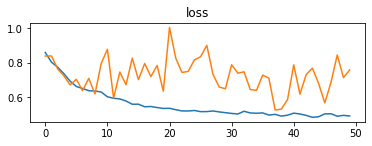

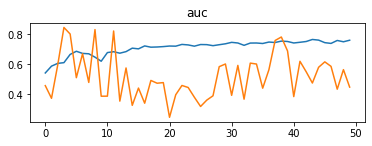

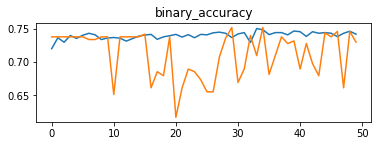

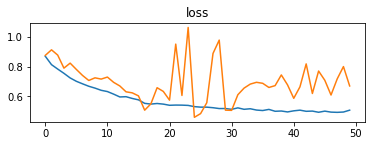

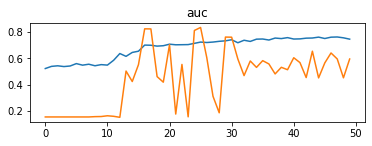

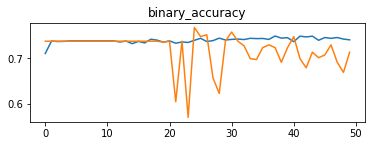

In [67]:
for i in history_cc.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_cc.history[i], label='train')
  pyplot.plot(history_cc.history['val_'+i], label='test')
  pyplot.show()

for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_mlo.history[i], label='train')
  pyplot.plot(history_mlo.history['val_'+i], label='test')
  pyplot.show()

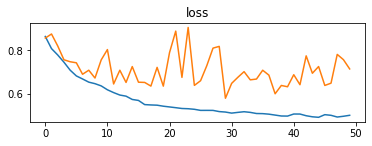

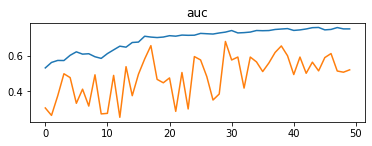

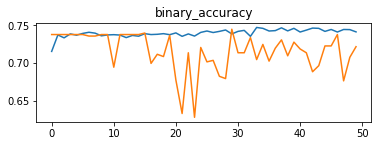

In [68]:
#bananasplit = [int(b) / int(m) for b,m in zip(banana, monkey)]


for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history[i], history_cc.history[i])] , label='train')
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history['val_'+i], history_cc.history['val_'+i])] , label='test')
  pyplot.show()

##Cross Validation 2/5

In [69]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]


gc.collect()

80928

In [70]:


i=1
#df_training.left_mlo.values[l]
m=[]
for j in range(0,n*i):

  m.append(j)

for j in range(n*i+n,len(labels_c)):
  m.append(j)

p=[]
for j in range(n*i,n*i+n):

  p.append(j)




###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[m], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[m], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[m], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[m], img_rows, img_cols, in_channel)

###labels
labels = labels_c[m]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[p] ,img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[p], img_rows, img_cols, in_channel)



labels_validation = labels_c[p]





In [71]:
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.compile(optimizer=optimizer,
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_cc=model_cc.fit(x={
                         "left_cc": x_train_left_cc,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=50,verbose=1,
                  #callbacks = cbks,
                  validation_data=(
                      {
                         "left_cc": x_validation_left_cc,

                         "right_cc":x_validation_right_cc},
                    labels_validation
                  ))

history_mlo=model_mlo.fit(x={"left_mlo": x_train_left_mlo,
                         "right_mlo":x_train_right_mlo},
                  y=labels,
                  epochs=50,verbose=1,
                 # callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "right_mlo":x_validation_right_mlo},
                    labels_validation
                  ))



(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Epoch 1/50
24/24 [==============================] - 7s 279ms/step - loss: 0.8677 - auc: 0.5240 - binary_accuracy: 0.7164 - val_loss: 0.9088 - val_auc: 0.1549 - val_binary_accuracy: 0.7238
Epoch 2/50
24/24 [==============================] - 5s 222ms/step - loss: 0.8207 - auc: 0.5147 - binary_accuracy: 0.7392 - val_loss: 0.9129 - val_auc: 0.1533 - val_binary_accuracy: 0.7238
Epoch 3/50
24/24 [==============================] - 5s 226ms/step - loss: 0.7804 - auc: 0.5395 - binary_accuracy: 0.7399 - val_loss: 0.8186 - val_auc: 0.1533 - val_binary_accuracy: 0.7238
Epoch 4/50
24/24 [==============================] - 5s 227ms/step - loss: 0.7474 - auc: 0.5531 - binary_accuracy: 0.7409 - val_loss: 0.8253 - val_auc: 0.1559 - val_binary_accuracy: 0.7238
Epoch 5/50
24/24 [==============================] - 5s 224ms/step - loss: 0.7254 - auc: 0.5306 - binary_accuracy: 0.7409 - val_loss: 0.7897 - val_auc: 0.2467 - val_binary_accuracy:

### Result

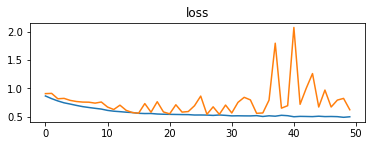

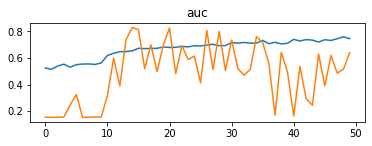

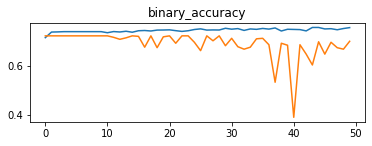

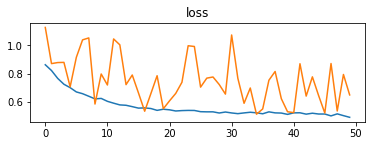

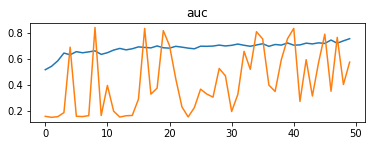

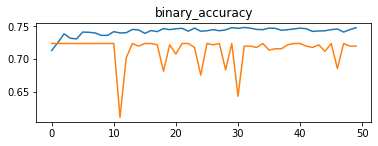

In [72]:
for i in history_cc.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_cc.history[i], label='train')
  pyplot.plot(history_cc.history['val_'+i], label='test')
  pyplot.show()

for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_mlo.history[i], label='train')
  pyplot.plot(history_mlo.history['val_'+i], label='test')
  pyplot.show()

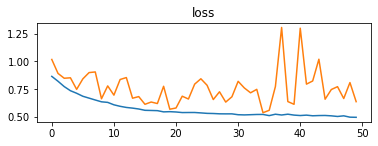

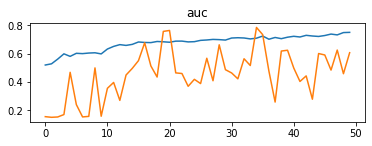

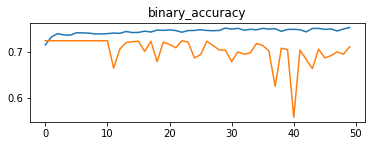

In [73]:
#bananasplit = [int(b) / int(m) for b,m in zip(banana, monkey)]


for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history[i], history_cc.history[i])] , label='train')
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history['val_'+i], history_cc.history['val_'+i])] , label='test')
  pyplot.show()

##Cross Validation 3/5

In [74]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

gc.collect()

20496

In [75]:
i=2


x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

#df_training.left_mlo.values[l]
m=[]
for j in range(0,n*i):

  m.append(j)

for j in range(n*i+n,len(labels_c)):
  m.append(j)

p=[]
for j in range(n*i,n*i+n):

  p.append(j)


print(len(p))

###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[m], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[m], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[m], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[m], img_rows, img_cols, in_channel)

###labels
labels = labels_c[m]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[p] ,img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[p], img_rows, img_cols, in_channel)



labels_validation = labels_c[p]





124


In [76]:
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.compile(optimizer=optimizer,
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_cc=model_cc.fit(x={
                         "left_cc": x_train_left_cc,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=50,verbose=1,
                  #callbacks = cbks,
                  validation_data=(
                      {
                         "left_cc": x_validation_left_cc,

                         "right_cc":x_validation_right_cc},
                    labels_validation
                  ))

history_mlo=model_mlo.fit(x={"left_mlo": x_train_left_mlo,
                         "right_mlo":x_train_right_mlo},
                  y=labels,
                  epochs=50,verbose=1,
                 # callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "right_mlo":x_validation_right_mlo},
                    labels_validation
                  ))



(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Epoch 1/50
24/24 [==============================] - 6s 256ms/step - loss: 0.8660 - auc: 0.5121 - binary_accuracy: 0.7114 - val_loss: 0.8885 - val_auc: 0.1148 - val_binary_accuracy: 0.7440
Epoch 2/50
24/24 [==============================] - 5s 224ms/step - loss: 0.8176 - auc: 0.5339 - binary_accuracy: 0.7342 - val_loss: 0.8798 - val_auc: 0.1098 - val_binary_accuracy: 0.7440
Epoch 3/50
24/24 [==============================] - 5s 226ms/step - loss: 0.7855 - auc: 0.5357 - binary_accuracy: 0.7345 - val_loss: 0.7855 - val_auc: 0.1126 - val_binary_accuracy: 0.7440
Epoch 4/50
24/24 [==============================] - 5s 220ms/step - loss: 0.7508 - auc: 0.5369 - binary_accuracy: 0.7372 - val_loss: 0.7422 - val_auc: 0.1906 - val_binary_accuracy: 0.7440
Epoch 5/50
24/24 [==============================] - 5s 223ms/step - loss: 0.7184 - auc: 0.5676 - binary_accuracy: 0.7372 - val_loss: 0.7588 - val_auc: 0.2626 - val_binary_accuracy:

### Result

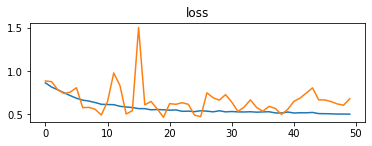

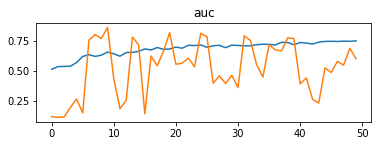

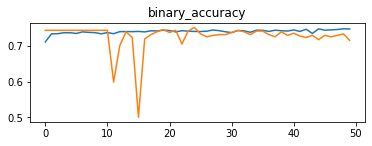

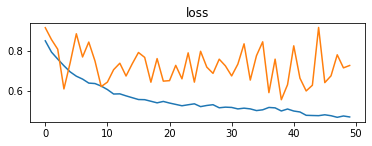

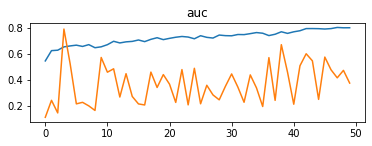

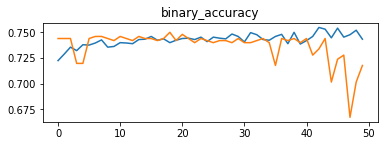

In [77]:
for i in history_cc.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_cc.history[i], label='train')
  pyplot.plot(history_cc.history['val_'+i], label='test')
  pyplot.show()

for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_mlo.history[i], label='train')
  pyplot.plot(history_mlo.history['val_'+i], label='test')
  pyplot.show()

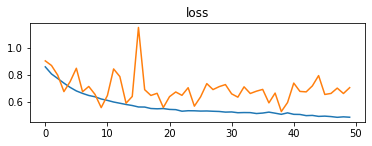

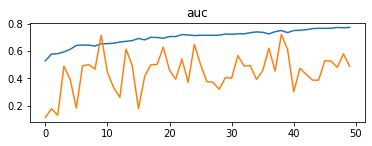

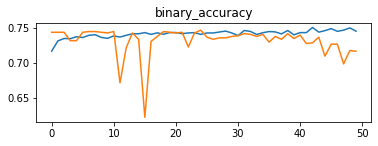

In [78]:
#bananasplit = [int(b) / int(m) for b,m in zip(banana, monkey)]


for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history[i], history_cc.history[i])] , label='train')
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history['val_'+i], history_cc.history['val_'+i])] , label='test')
  pyplot.show()

##Cross Validation 4/5

In [79]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

gc.collect()

6833

In [80]:
i=3


x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]


#df_training.left_mlo.values[l]
m=[]
for j in range(0,n*i):

  m.append(j)

for j in range(n*i+n,len(labels_c)):
  m.append(j)

p=[]
for j in range(n*i,n*i+n):

  p.append(j)




###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[m], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[m], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[m], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[m], img_rows, img_cols, in_channel)

###labels
labels = labels_c[m]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[p] ,img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[p], img_rows, img_cols, in_channel)



labels_validation = labels_c[p]





In [81]:
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.compile(optimizer=optimizer,
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_cc=model_cc.fit(x={
                         "left_cc": x_train_left_cc,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=50,verbose=1,
                  #callbacks = cbks,
                  validation_data=(
                      {
                         "left_cc": x_validation_left_cc,

                         "right_cc":x_validation_right_cc},
                    labels_validation
                  ))

history_mlo=model_mlo.fit(x={"left_mlo": x_train_left_mlo,
                         "right_mlo":x_train_right_mlo},
                  y=labels,
                  epochs=50,verbose=1,
                 # callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "right_mlo":x_validation_right_mlo},
                    labels_validation
                  ))



(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Epoch 1/50
24/24 [==============================] - 6s 254ms/step - loss: 0.8603 - auc: 0.5115 - binary_accuracy: 0.7204 - val_loss: 0.8275 - val_auc: 0.5136 - val_binary_accuracy: 0.7399
Epoch 2/50
24/24 [==============================] - 5s 222ms/step - loss: 0.8168 - auc: 0.5326 - binary_accuracy: 0.7366 - val_loss: 0.7970 - val_auc: 0.4673 - val_binary_accuracy: 0.7399
Epoch 3/50
24/24 [==============================] - 5s 224ms/step - loss: 0.7653 - auc: 0.5880 - binary_accuracy: 0.7409 - val_loss: 0.7678 - val_auc: 0.4717 - val_binary_accuracy: 0.7399
Epoch 4/50
24/24 [==============================] - 5s 219ms/step - loss: 0.7344 - auc: 0.5989 - binary_accuracy: 0.7399 - val_loss: 0.7536 - val_auc: 0.4738 - val_binary_accuracy: 0.7399
Epoch 5/50
24/24 [==============================] - 5s 219ms/step - loss: 0.7123 - auc: 0.5983 - binary_accuracy: 0.7416 - val_loss: 0.7191 - val_auc: 0.5577 - val_binary_accuracy:

### Result

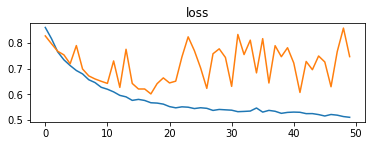

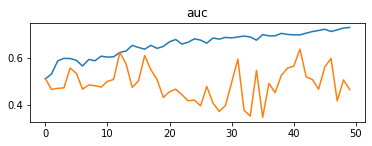

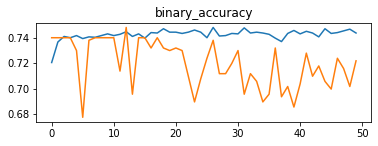

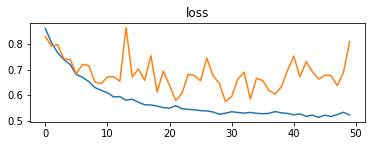

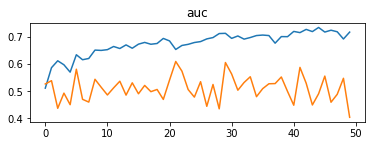

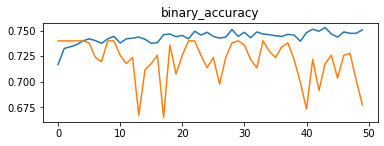

In [82]:
for i in history_cc.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_cc.history[i], label='train')
  pyplot.plot(history_cc.history['val_'+i], label='test')
  pyplot.show()

for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_mlo.history[i], label='train')
  pyplot.plot(history_mlo.history['val_'+i], label='test')
  pyplot.show()

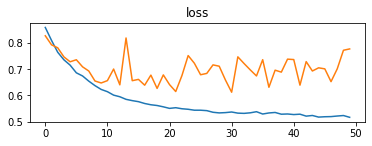

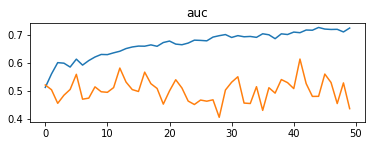

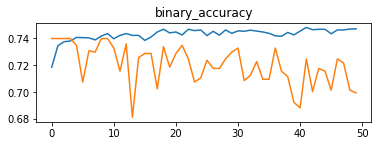

In [83]:
#bananasplit = [int(b) / int(m) for b,m in zip(banana, monkey)]


for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history[i], history_cc.history[i])] , label='train')
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history['val_'+i], history_cc.history['val_'+i])] , label='test')
  pyplot.show()

##Cross Validation 5/5

In [84]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]


gc.collect()

121581

In [85]:
i=4


x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]


#df_training.left_mlo.values[l]
m=[]
for j in range(0,n*i):

  m.append(j)

for j in range(n*i+n,len(labels_c)-1):
  m.append(j)

p=[]
for j in range(n*i,n*i+n):

  p.append(j)




###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[m], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[m], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[m], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[m], img_rows, img_cols, in_channel)

###labels
labels = labels_c[m]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[p] ,img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[p], img_rows, img_cols, in_channel)



labels_validation = labels_c[p]





In [86]:
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.compile(optimizer=optimizer,
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_cc=model_cc.fit(x={
                         "left_cc": x_train_left_cc,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=50,verbose=1,
                  #callbacks = cbks,
                  validation_data=(
                      {
                         "left_cc": x_validation_left_cc,

                         "right_cc":x_validation_right_cc},
                    labels_validation
                  ))

history_mlo=model_mlo.fit(x={"left_mlo": x_train_left_mlo,
                         "right_mlo":x_train_right_mlo},
                  y=labels,
                  epochs=50,verbose=1,
                 # callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "right_mlo":x_validation_right_mlo},
                    labels_validation
                  ))



(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Epoch 1/50
24/24 [==============================] - 6s 256ms/step - loss: 0.8585 - auc: 0.5507 - binary_accuracy: 0.7056 - val_loss: 0.9268 - val_auc: 0.1909 - val_binary_accuracy: 0.7460
Epoch 2/50
24/24 [==============================] - 5s 224ms/step - loss: 0.7992 - auc: 0.6195 - binary_accuracy: 0.7271 - val_loss: 0.9823 - val_auc: 0.1274 - val_binary_accuracy: 0.7460
Epoch 3/50
24/24 [==============================] - 5s 228ms/step - loss: 0.7673 - auc: 0.6249 - binary_accuracy: 0.7318 - val_loss: 0.9337 - val_auc: 0.1338 - val_binary_accuracy: 0.7460
Epoch 4/50
24/24 [==============================] - 5s 223ms/step - loss: 0.7232 - auc: 0.6597 - binary_accuracy: 0.7392 - val_loss: 0.9122 - val_auc: 0.1918 - val_binary_accuracy: 0.7460
Epoch 5/50
24/24 [==============================] - 5s 222ms/step - loss: 0.7014 - auc: 0.6595 - binary_accuracy: 0.7325 - val_loss: 0.9497 - val_auc: 0.1271 - val_binary_accuracy:

### Result

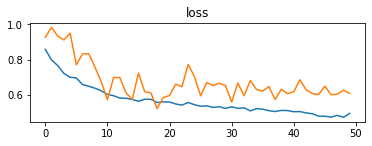

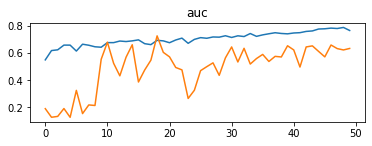

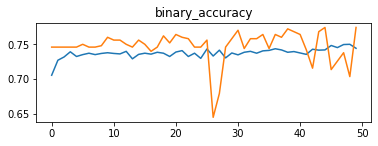

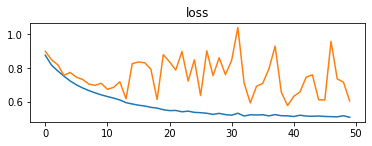

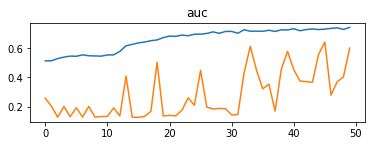

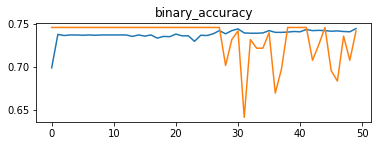

In [87]:
for i in history_cc.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_cc.history[i], label='train')
  pyplot.plot(history_cc.history['val_'+i], label='test')
  pyplot.show()

for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_mlo.history[i], label='train')
  pyplot.plot(history_mlo.history['val_'+i], label='test')
  pyplot.show()

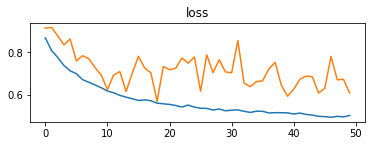

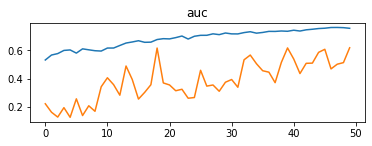

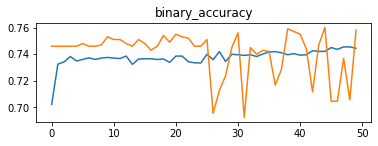

In [88]:
#bananasplit = [int(b) / int(m) for b,m in zip(banana, monkey)]


for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history[i], history_cc.history[i])] , label='train')
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history['val_'+i], history_cc.history['val_'+i])] , label='test')
  pyplot.show()

#Best Model with cross validation trained per part adam

##subdivide the dataset


In [89]:
subsets=[]
index=range(0,1000)
n=int(len(df_training.values)/7)
l=(1000)
"""for i in range(0, 1000, n):
        subsets.append(index[i:i+n])"""
n

124

In [90]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

labels_c = df_training[["lb","lm","rb","rm"]].reset_index(drop=True)
labels_c=labels_c.values
w=calculating_class_weights(labels_c)
l_f=get_weighted_loss(w)
labels_c

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1]])

##Model

In [91]:
#  V 2

def resnetBlock(inputimage,k=2,striede=1, name=""):

  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(inputimage)


  activation=keras.activations.relu(batch_normalize )

  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(3,3),
    name="",
  padding="same"
  )(activation)

  conv1x1_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(1,1),
    name="",
#    activation=keras.activations.relu
  )(activation)


  batch_normalize_2 = keras.layers.BatchNormalization( axis=-1,name="")(conv3x3_1)

  activation2=keras.activations.relu(batch_normalize_2 )
  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    kernel_size=(3,3),
    name="",
    padding="same"
  )(activation2)

  outputs=keras.layers.Add()([conv3x3_1,conv1x1_1])
  return outputs




In [92]:
def resNetLayers(inputimage,name=""):
  block1=resnetBlock(inputimage,k=16,name="block1")
  #block2=resnetBlock(block1,k=16,name="block2")
  block3=resnetBlock(block1,k=16,striede=2,name="block3")
  #block4=resnetBlock(block3,k=32,name="block4")
  block5=resnetBlock(block3,k=32,striede=2,name="block5")
  pool=keras.layers.AveragePooling2D(
      pool_size=(3,3), strides=2, padding='same', name='' #(3,3)
  )(block5)
  #block6=resnetBlock(block5,k=32,striede=2,name="block6")
  block7=resnetBlock(pool,k=32,striede=2,name="block7")
  #block8=resnetBlock(inputfilter=128,k=128,name="block8")(block7)
  
  #block10=resnetBlock(inputfilter=256,k=256,name="block10")(block9)
  return block7

def singleViewResnet(inputimage, name=""):

  conv7x7=tf.keras.layers.Conv2D(
    filters=16,
    strides=2,
    kernel_size=(5,5),
    name="",
    activation=keras.activations.relu
  )(inputimage)

  pool3x3=keras.layers.AveragePooling2D(
      pool_size=(2,2), strides=2, padding='same', name='' #(3,3)
  )(conv7x7)

  resNetL=resNetLayers(pool3x3,name="")
  print(resNetL.shape)
  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(resNetL)

  relu=keras.activations.relu(batch_normalize)
  
  return relu




In [93]:
def view_wise_mlo(img_rows=300, img_cols=300):

  left_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_mlo"
  )  
  right_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_mlo"
  )


  mlo_resnet_left=singleViewResnet(left_mlo_input)
  mlo_resent_right=singleViewResnet(right_mlo_input)

  avg_pool_mlo_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resnet_left)
  avg_pool_mlo_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resent_right)

  mlo=keras.layers.Concatenate(axis=-1)([avg_pool_mlo_left, avg_pool_mlo_right])
 
  mlo_flatten=tf.keras.layers.Flatten()(mlo)


  mlo_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_flatten)
        )
      )
  mlo_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_dense1)
        )
      ) 
  
  mlo_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(mlo_dense3)
    )
  

  output=mlo_dense2

  output=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(output)
    )
  
 
  output=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(output)
    )

  return keras.Model(
      inputs=[left_mlo_input, right_mlo_input],
      outputs=output,name="view-wise"
  )
model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.summary()
#keras.utils.plot_model(model, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise.png", show_shapes=True, expand_nested=False)

def view_wise_cc(img_rows=300, img_cols=300):
  left_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_cc")
  right_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_cc"
  )  

  #cc_resnet=singleViewResnet(name="cc_resnet")
  #mlo_resnet=singleViewResnet(name="mlo_resnet")

  cc_resnet_left=singleViewResnet(left_cc_input)
  cc_resnet_right=singleViewResnet(right_cc_input)


  avg_pool_cc_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_left)
  avg_pool_cc_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_right)


  cc=keras.layers.Concatenate(axis=-1)([avg_pool_cc_left, avg_pool_cc_right])

  cc_flatten=tf.keras.layers.Flatten()(cc)



  cc_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_flatten)
        )
      )
  cc_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_dense1)
        )
      ) 
 
  cc_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(cc_dense3)
    )
  

  output=cc_dense2

  output=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(output)
    )
  
 
  output=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(output)
    )

  return keras.Model(
      inputs=[left_cc_input, right_cc_input],
      outputs=output,name="view-wise"
  )
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.summary()
#keras.utils.plot_model(model, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise.png", show_shapes=True, expand_nested=False)






(None, 8, 6, 32)
(None, 8, 6, 32)
Model: "view-wise"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_mlo (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_mlo (InputLayer)          [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_520 (Conv2D)             (None, 254, 190, 16) 1216        left_mlo[0][0]                   
__________________________________________________________________________________________________
conv2d_533 (Conv2D)             (None, 254, 190, 16) 1216        right_mlo[0][0]                  
________________________________________________________

##utilities

In [94]:
batch_size=32
step_per_epoch=len(x_train_left_mlo)/batch_size

cbks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
        tf.keras.callbacks.ModelCheckpoint(
                    "/checkpoint_auc1",
                    monitor="val_auc",
                    mode='max',
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
                    
        ),
       tf.keras.callbacks.ModelCheckpoint(
                    "/checkpoint_loss1",
                    monitor="val_loss",
                    
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
       )]


optimizer=keras.optimizers.Adam(lr=0.001)
#optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
#optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07)


## Cross Validation 1/5

In [95]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

gc.collect()

0

In [96]:


###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[n:-1], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[n:-1], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[n:-1], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[n:-1], img_rows, img_cols, in_channel)

###labels
labels = labels_c[n:-1]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[0:n], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[0:n], img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[0:n], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[0:n], img_rows, img_cols, in_channel)



labels_validation = labels_c[0:n]





In [97]:
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.compile(optimizer=optimizer,
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_cc=model_cc.fit(x={
                         "left_cc": x_train_left_cc,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=50,verbose=1,
                  #callbacks = cbks,
                  validation_data=(
                      {
                         "left_cc": x_validation_left_cc,

                         "right_cc":x_validation_right_cc},
                    labels_validation
                  ))

history_mlo=model_mlo.fit(x={"left_mlo": x_train_left_mlo,
                         "right_mlo":x_train_right_mlo},
                  y=labels,
                  epochs=50,verbose=1,
                 # callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "right_mlo":x_validation_right_mlo},
                    labels_validation
                  ))



(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Epoch 1/50
24/24 [==============================] - 6s 266ms/step - loss: 0.8544 - auc: 0.5268 - binary_accuracy: 0.7100 - val_loss: 0.8919 - val_auc: 0.1559 - val_binary_accuracy: 0.7379
Epoch 2/50
24/24 [==============================] - 5s 220ms/step - loss: 0.7653 - auc: 0.6084 - binary_accuracy: 0.7291 - val_loss: 0.8164 - val_auc: 0.1526 - val_binary_accuracy: 0.7379
Epoch 3/50
24/24 [==============================] - 5s 226ms/step - loss: 0.7032 - auc: 0.6470 - binary_accuracy: 0.7349 - val_loss: 0.6629 - val_auc: 0.8291 - val_binary_accuracy: 0.7379
Epoch 4/50
24/24 [==============================] - 5s 224ms/step - loss: 0.6550 - auc: 0.6861 - binary_accuracy: 0.7386 - val_loss: 0.6049 - val_auc: 0.8315 - val_binary_accuracy: 0.7379
Epoch 5/50
24/24 [==============================] - 5s 220ms/step - loss: 0.6381 - auc: 0.6821 - binary_accuracy: 0.7312 - val_loss: 0.6446 - val_auc: 0.7303 - val_binary_accuracy:

### Result

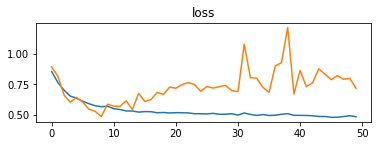

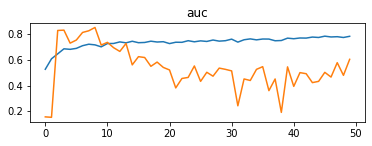

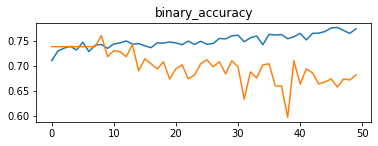

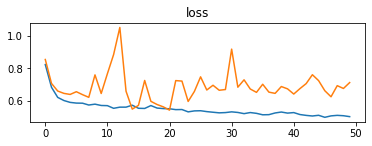

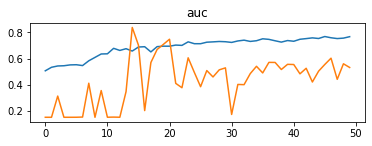

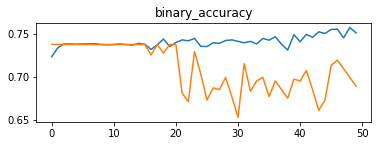

In [98]:
for i in history_cc.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_cc.history[i], label='train')
  pyplot.plot(history_cc.history['val_'+i], label='test')
  pyplot.show()

for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_mlo.history[i], label='train')
  pyplot.plot(history_mlo.history['val_'+i], label='test')
  pyplot.show()

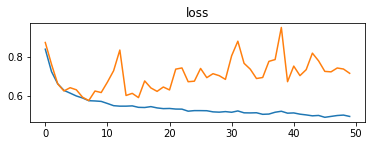

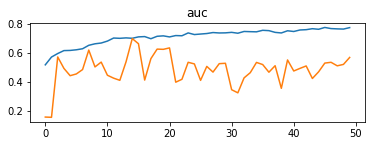

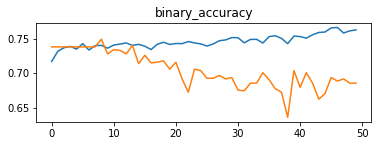

In [99]:
#bananasplit = [int(b) / int(m) for b,m in zip(banana, monkey)]


for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history[i], history_cc.history[i])] , label='train')
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history['val_'+i], history_cc.history['val_'+i])] , label='test')
  pyplot.show()

##Cross Validation 2/5

In [100]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]


gc.collect()

140701

In [101]:


i=1
#df_training.left_mlo.values[l]
m=[]
for j in range(0,n*i):

  m.append(j)

for j in range(n*i+n,len(labels_c)):
  m.append(j)

p=[]
for j in range(n*i,n*i+n):

  p.append(j)




###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[m], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[m], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[m], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[m], img_rows, img_cols, in_channel)

###labels
labels = labels_c[m]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[p] ,img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[p], img_rows, img_cols, in_channel)



labels_validation = labels_c[p]





In [102]:
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.compile(optimizer=optimizer,
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_cc=model_cc.fit(x={
                         "left_cc": x_train_left_cc,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=50,verbose=1,
                  #callbacks = cbks,
                  validation_data=(
                      {
                         "left_cc": x_validation_left_cc,

                         "right_cc":x_validation_right_cc},
                    labels_validation
                  ))

history_mlo=model_mlo.fit(x={"left_mlo": x_train_left_mlo,
                         "right_mlo":x_train_right_mlo},
                  y=labels,
                  epochs=50,verbose=1,
                 # callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "right_mlo":x_validation_right_mlo},
                    labels_validation
                  ))



(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Epoch 1/50
24/24 [==============================] - 6s 259ms/step - loss: 0.8003 - auc: 0.5438 - binary_accuracy: 0.7241 - val_loss: 0.8371 - val_auc: 0.1533 - val_binary_accuracy: 0.7238
Epoch 2/50
24/24 [==============================] - 5s 221ms/step - loss: 0.6592 - auc: 0.5413 - binary_accuracy: 0.7396 - val_loss: 0.6860 - val_auc: 0.1533 - val_binary_accuracy: 0.7238
Epoch 3/50
24/24 [==============================] - 5s 217ms/step - loss: 0.6020 - auc: 0.5503 - binary_accuracy: 0.7409 - val_loss: 0.6565 - val_auc: 0.3248 - val_binary_accuracy: 0.7238
Epoch 4/50
24/24 [==============================] - 5s 215ms/step - loss: 0.5871 - auc: 0.5450 - binary_accuracy: 0.7409 - val_loss: 0.7074 - val_auc: 0.1548 - val_binary_accuracy: 0.7238
Epoch 5/50
24/24 [==============================] - 5s 220ms/step - loss: 0.5778 - auc: 0.5823 - binary_accuracy: 0.7416 - val_loss: 0.6375 - val_auc: 0.4266 - val_binary_accuracy:

### Result

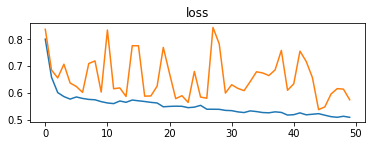

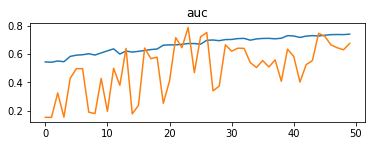

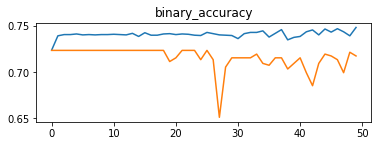

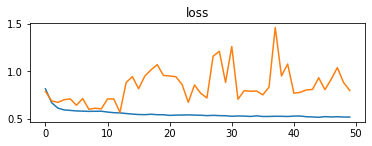

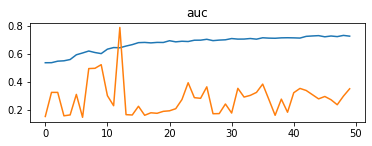

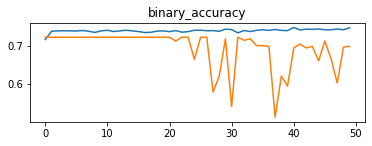

In [103]:
for i in history_cc.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_cc.history[i], label='train')
  pyplot.plot(history_cc.history['val_'+i], label='test')
  pyplot.show()

for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_mlo.history[i], label='train')
  pyplot.plot(history_mlo.history['val_'+i], label='test')
  pyplot.show()

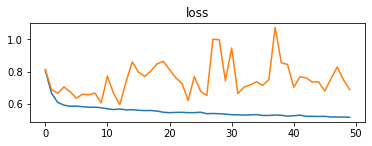

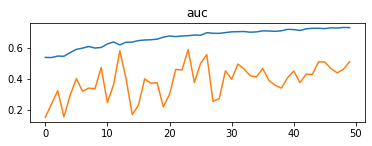

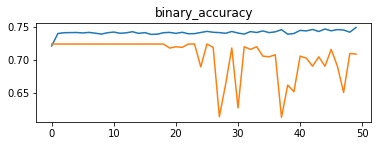

In [104]:
#bananasplit = [int(b) / int(m) for b,m in zip(banana, monkey)]


for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history[i], history_cc.history[i])] , label='train')
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history['val_'+i], history_cc.history['val_'+i])] , label='test')
  pyplot.show()

##Cross Validation 3/5

In [105]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

gc.collect()

121785

In [106]:
i=2


x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

#df_training.left_mlo.values[l]
m=[]
for j in range(0,n*i):

  m.append(j)

for j in range(n*i+n,len(labels_c)):
  m.append(j)

p=[]
for j in range(n*i,n*i+n):

  p.append(j)


print(len(p))

###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[m], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[m], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[m], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[m], img_rows, img_cols, in_channel)

###labels
labels = labels_c[m]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[p] ,img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[p], img_rows, img_cols, in_channel)



labels_validation = labels_c[p]





124


In [107]:
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.compile(optimizer=optimizer,
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_cc=model_cc.fit(x={
                         "left_cc": x_train_left_cc,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=50,verbose=1,
                  #callbacks = cbks,
                  validation_data=(
                      {
                         "left_cc": x_validation_left_cc,

                         "right_cc":x_validation_right_cc},
                    labels_validation
                  ))

history_mlo=model_mlo.fit(x={"left_mlo": x_train_left_mlo,
                         "right_mlo":x_train_right_mlo},
                  y=labels,
                  epochs=50,verbose=1,
                 # callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "right_mlo":x_validation_right_mlo},
                    labels_validation
                  ))



(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Epoch 1/50
24/24 [==============================] - 6s 252ms/step - loss: 0.8532 - auc: 0.5170 - binary_accuracy: 0.7134 - val_loss: 0.7878 - val_auc: 0.2288 - val_binary_accuracy: 0.7440
Epoch 2/50
24/24 [==============================] - 5s 224ms/step - loss: 0.7027 - auc: 0.5481 - binary_accuracy: 0.7359 - val_loss: 0.6707 - val_auc: 0.1124 - val_binary_accuracy: 0.7440
Epoch 3/50
24/24 [==============================] - 5s 222ms/step - loss: 0.6318 - auc: 0.5335 - binary_accuracy: 0.7369 - val_loss: 0.7093 - val_auc: 0.1124 - val_binary_accuracy: 0.7440
Epoch 4/50
24/24 [==============================] - 5s 221ms/step - loss: 0.6099 - auc: 0.5350 - binary_accuracy: 0.7376 - val_loss: 0.6333 - val_auc: 0.1124 - val_binary_accuracy: 0.7440
Epoch 5/50
24/24 [==============================] - 5s 223ms/step - loss: 0.5994 - auc: 0.5257 - binary_accuracy: 0.7376 - val_loss: 0.6686 - val_auc: 0.1124 - val_binary_accuracy:

### Result

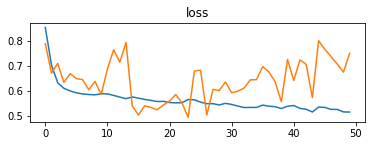

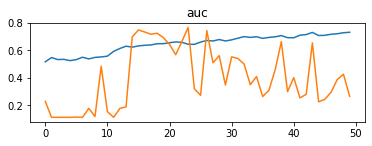

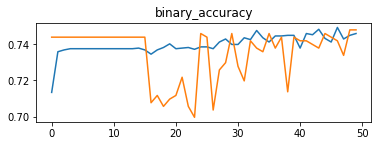

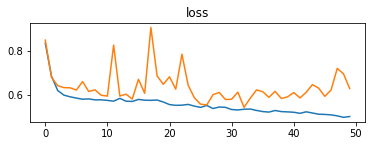

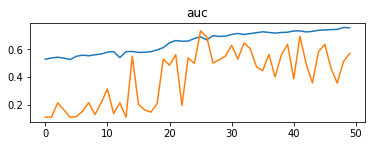

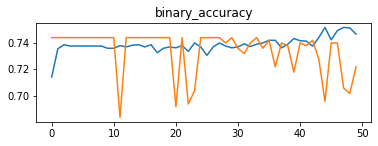

In [108]:
for i in history_cc.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_cc.history[i], label='train')
  pyplot.plot(history_cc.history['val_'+i], label='test')
  pyplot.show()

for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_mlo.history[i], label='train')
  pyplot.plot(history_mlo.history['val_'+i], label='test')
  pyplot.show()

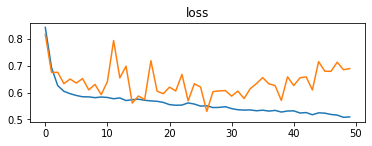

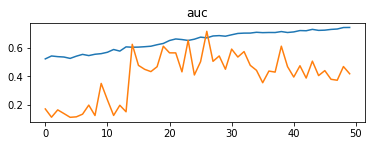

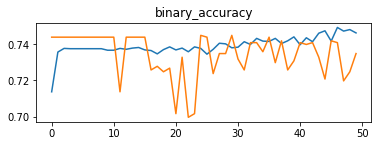

In [109]:
#bananasplit = [int(b) / int(m) for b,m in zip(banana, monkey)]


for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history[i], history_cc.history[i])] , label='train')
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history['val_'+i], history_cc.history['val_'+i])] , label='test')
  pyplot.show()

##Cross Validation 4/5

In [110]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]

gc.collect()

121775

In [111]:
i=3


x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]


#df_training.left_mlo.values[l]
m=[]
for j in range(0,n*i):

  m.append(j)

for j in range(n*i+n,len(labels_c)):
  m.append(j)

p=[]
for j in range(n*i,n*i+n):

  p.append(j)




###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[m], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[m], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[m], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[m], img_rows, img_cols, in_channel)

###labels
labels = labels_c[m]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[p] ,img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[p], img_rows, img_cols, in_channel)



labels_validation = labels_c[p]





In [112]:
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.compile(optimizer=optimizer,
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_cc=model_cc.fit(x={
                         "left_cc": x_train_left_cc,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=50,verbose=1,
                  #callbacks = cbks,
                  validation_data=(
                      {
                         "left_cc": x_validation_left_cc,

                         "right_cc":x_validation_right_cc},
                    labels_validation
                  ))

history_mlo=model_mlo.fit(x={"left_mlo": x_train_left_mlo,
                         "right_mlo":x_train_right_mlo},
                  y=labels,
                  epochs=50,verbose=1,
                 # callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "right_mlo":x_validation_right_mlo},
                    labels_validation
                  ))



(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Epoch 1/50
24/24 [==============================] - 6s 252ms/step - loss: 0.8495 - auc: 0.4984 - binary_accuracy: 0.7103 - val_loss: 0.7362 - val_auc: 0.5354 - val_binary_accuracy: 0.7399
Epoch 2/50
24/24 [==============================] - 5s 217ms/step - loss: 0.6933 - auc: 0.5044 - binary_accuracy: 0.7379 - val_loss: 0.6367 - val_auc: 0.5170 - val_binary_accuracy: 0.7399
Epoch 3/50
24/24 [==============================] - 5s 219ms/step - loss: 0.6274 - auc: 0.5014 - binary_accuracy: 0.7382 - val_loss: 0.6051 - val_auc: 0.5118 - val_binary_accuracy: 0.7399
Epoch 4/50
24/24 [==============================] - 5s 220ms/step - loss: 0.6052 - auc: 0.5123 - binary_accuracy: 0.7382 - val_loss: 0.5918 - val_auc: 0.5159 - val_binary_accuracy: 0.7399
Epoch 5/50
24/24 [==============================] - 5s 216ms/step - loss: 0.5968 - auc: 0.5115 - binary_accuracy: 0.7382 - val_loss: 0.5857 - val_auc: 0.5472 - val_binary_accuracy:

### Result

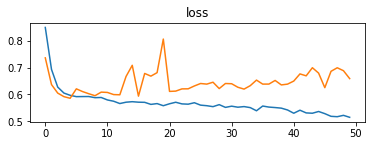

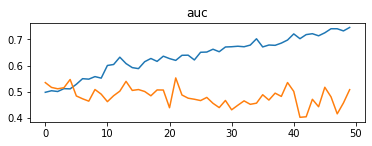

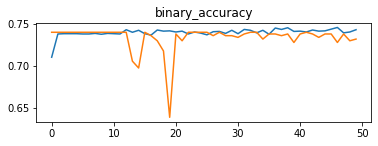

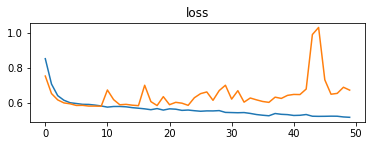

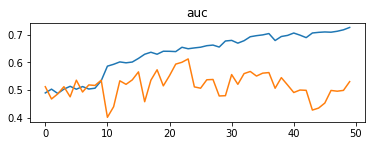

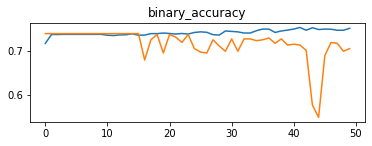

In [113]:
for i in history_cc.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_cc.history[i], label='train')
  pyplot.plot(history_cc.history['val_'+i], label='test')
  pyplot.show()

for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_mlo.history[i], label='train')
  pyplot.plot(history_mlo.history['val_'+i], label='test')
  pyplot.show()

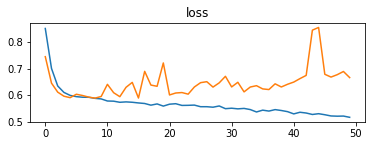

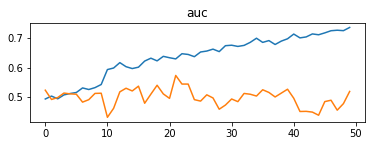

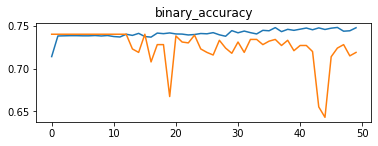

In [114]:
#bananasplit = [int(b) / int(m) for b,m in zip(banana, monkey)]


for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history[i], history_cc.history[i])] , label='train')
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history['val_'+i], history_cc.history['val_'+i])] , label='test')
  pyplot.show()

##Cross Validation 5/5

In [115]:
x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]


gc.collect()

121832

In [116]:
i=4


x_train_left_mlo=[]
x_train_left_cc=[]
x_train_right_mlo=[]
x_train_right_cc=[]

x_validation_left_mlo=[]
x_validation_left_cc=[]
x_validation_right_mlo=[]
x_validation_right_cc=[]


#df_training.left_mlo.values[l]
m=[]
for j in range(0,n*i):

  m.append(j)

for j in range(n*i+n,len(labels_c)-1):
  m.append(j)

p=[]
for j in range(n*i,n*i+n):

  p.append(j)




###Left
x_train_left_mlo = read_spectograms(df_training.left_mlo.values[m], img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values[m], img_rows, img_cols, in_channel)
###Right
x_train_right_mlo =  read_spectograms(df_training.right_mlo.values[m], img_rows, img_cols, in_channel)
x_train_right_cc=  read_spectograms(df_training.right_cc.values[m], img_rows, img_cols, in_channel)

###labels
labels = labels_c[m]


x_validation_left_mlo =  read_spectograms(df_training.left_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_left_cc=  read_spectograms(df_training.left_cc.values[p] ,img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_training.right_mlo.values[p], img_rows, img_cols, in_channel)
x_validation_right_cc=  read_spectograms(df_training.right_cc.values[p], img_rows, img_cols, in_channel)



labels_validation = labels_c[p]





In [117]:
model_cc=view_wise_cc(img_rows, img_cols)
model_cc.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

model_mlo=view_wise_mlo(img_rows, img_cols)
model_mlo.compile(optimizer=optimizer,
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history_cc=model_cc.fit(x={
                         "left_cc": x_train_left_cc,
                         "right_cc":x_train_right_cc},
                  y=labels,
                  epochs=50,verbose=1,
                  #callbacks = cbks,
                  validation_data=(
                      {
                         "left_cc": x_validation_left_cc,

                         "right_cc":x_validation_right_cc},
                    labels_validation
                  ))

history_mlo=model_mlo.fit(x={"left_mlo": x_train_left_mlo,
                         "right_mlo":x_train_right_mlo},
                  y=labels,
                  epochs=50,verbose=1,
                 # callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "right_mlo":x_validation_right_mlo},
                    labels_validation
                  ))



(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Epoch 1/50
24/24 [==============================] - 6s 252ms/step - loss: 0.8260 - auc: 0.5246 - binary_accuracy: 0.7207 - val_loss: 0.7673 - val_auc: 0.3883 - val_binary_accuracy: 0.7460
Epoch 2/50
24/24 [==============================] - 5s 220ms/step - loss: 0.6775 - auc: 0.5289 - binary_accuracy: 0.7369 - val_loss: 0.6944 - val_auc: 0.1276 - val_binary_accuracy: 0.7460
Epoch 3/50
24/24 [==============================] - 5s 220ms/step - loss: 0.6155 - auc: 0.5455 - binary_accuracy: 0.7372 - val_loss: 0.6417 - val_auc: 0.2011 - val_binary_accuracy: 0.7460
Epoch 4/50
24/24 [==============================] - 5s 216ms/step - loss: 0.5966 - auc: 0.5404 - binary_accuracy: 0.7372 - val_loss: 0.6310 - val_auc: 0.2031 - val_binary_accuracy: 0.7460
Epoch 5/50
24/24 [==============================] - 5s 213ms/step - loss: 0.5885 - auc: 0.5507 - binary_accuracy: 0.7372 - val_loss: 0.6408 - val_auc: 0.1247 - val_binary_accuracy:

### Result

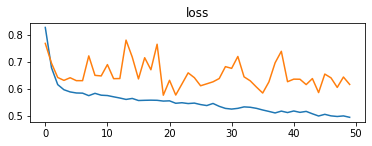

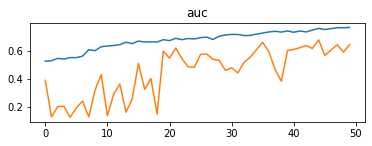

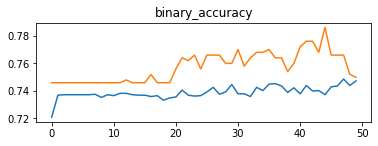

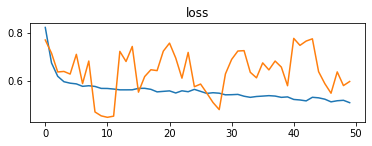

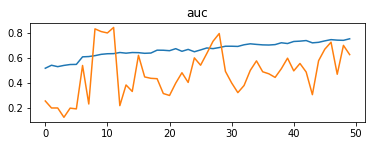

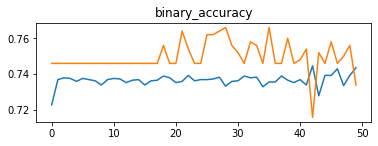

In [118]:
for i in history_cc.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_cc.history[i], label='train')
  pyplot.plot(history_cc.history['val_'+i], label='test')
  pyplot.show()

for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history_mlo.history[i], label='train')
  pyplot.plot(history_mlo.history['val_'+i], label='test')
  pyplot.show()

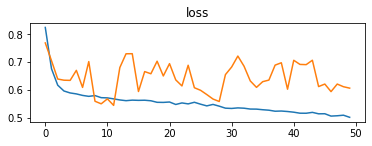

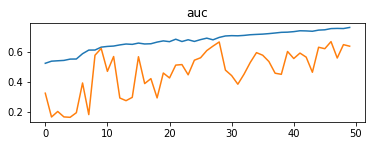

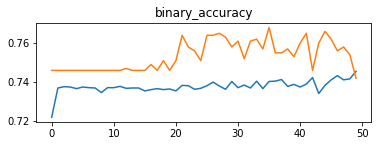

In [119]:
#bananasplit = [int(b) / int(m) for b,m in zip(banana, monkey)]


for i in history_mlo.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history[i], history_cc.history[i])] , label='train')
  pyplot.plot([i/2+ j/2 for i, j in zip(history_mlo.history['val_'+i], history_cc.history['val_'+i])] , label='test')
  pyplot.show()